<center><font size="10">Corporación Favorita <br><br>Store Sales</font></center>

**<font size=5>Acknowledgements:</font>**

# General

* **Data Type**: Tabular data
* **Problem Type**: Forecast store sales 2 weeks ahead of time - an **offline time-series supervised regression** task
* **Performance Measure / Evaluation Metric**: *Root Mean Squared Logarithmic Error*

$$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\ln (1 + \hat{y}_i) - \ln (1 + y_i)\right)^2}$$

* $n$ - total number of instances,
* $\hat{y}_i$ - predicted value of the target for instance (i),
*  $y_i$ - actual value of the target for instance (i), 
* $\ln$ - natural logarithm.

## Assumptions:
* 

## Submission File
For each id in the test set, you must predict a value for the sales variable. The file should contain a header and have the following format:
<pre>id,sales
3000888,0.0
3000889,0.0
3000890,0.0
3000891,0.0
3000892,0.0
...</pre>

## Imports

In [1]:
# suppress pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# statisticsnums3
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import curdoc
import pandas_bokeh

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10)

# tsa = time series analysis
from statsmodels.tsa.deterministic import (DeterministicProcess, 
    CalendarFourier)
from statsmodels.graphics.tsaplots import plot_pacf

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

# custom sklearn based transformers
from df_transformers import *

In [2]:
pandas_bokeh.output_notebook()

# default plot theme for bokeh
curdoc().theme = 'dark_minimal'

Loading BokehJS ...

# Load Data
## Train Set
### Main
* The training data, comprising time series of <u>features</u> <code>store_nbr, family, and onpromotion</code> as well as the <u>target</u> <code>sales</code>.
* <u>store_nbr</u> identifies the store at which the products are sold.
* <u>family</u> identifies the type of product sold.
* <u>sales</u> gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* <u>onpromotion</u> gives the total number of items in a product family that were being promoted at a store at a given date.


In [3]:
# read in train data
sales_train = pd.read_csv('data/favorita_store_sales/train.csv', 
                         index_col='date', parse_dates=['date'])

In [4]:
sales_train.head(2)

id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0

In [5]:
print(f"# rows: {sales_train.size:,}")

# rows: 15,004,440


In [6]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


### Stores
* Store metadata, including city, state, type, and cluster.
* cluster is a grouping of similar stores.

In [7]:
stores = pd.read_csv('data/favorita_store_sales/stores.csv')
stores.head(1)

store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13

In [8]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


### Oil
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [9]:
oil = pd.read_csv('data/favorita_store_sales/oil.csv', index_col='date',
                  parse_dates=['date'])
oil.head(1)

dcoilwtico
date                  
2013-01-01         NaN

In [10]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dcoilwtico  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


### Holiday Events
* Holidays and Events, with metadata
* NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
* Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [11]:
holidays = pd.read_csv('data/favorita_store_sales/holidays_events.csv',
                       index_col='date', parse_dates=['date'])
holidays.head(2)

type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False

In [12]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         350 non-null    object
 1   locale       350 non-null    object
 2   locale_name  350 non-null    object
 3   description  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


### Transactions

In [13]:
transactions = pd.read_csv('data/favorita_store_sales/transactions.csv',
                           index_col='date', parse_dates=['date'])
transactions.head(2)

store_nbr  transactions
date                               
2013-01-01         25           770
2013-01-02          1          2111

In [14]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83488 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   store_nbr     83488 non-null  int64
 1   transactions  83488 non-null  int64
dtypes: int64(2)
memory usage: 1.9 MB


## Test Set

In [15]:
sales_test = pd.read_csv('data/favorita_store_sales/test.csv', 
                        index_col='date', parse_dates=['date'])
sales_test.head(1)

id  store_nbr      family  onpromotion
date                                                   
2017-08-16  3000888          1  AUTOMOTIVE            0

In [16]:
sales_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


# EDA
Areas plan to explore:
1. *Trend* : Overall trend in sales for the company across all stores.
    * Overall, the sales has doubled from 2013 to 2018.
    * If we are going to use models like <font color='blue'>XGBoost</font> we need to filter trend out of the equation.</font>

2. *Stores Operating* : How long each store has opeated and their rough sales history. 
    * Some stores have excisted only a few years, though most of them operated at least half of the given time frame. 
    * Remove sales data from not excisting times.
    * When predicting sales, we need to construct ML model for each separately.
    

3. *Seasonality* : Capture seasonality. Bi-weekly salary may have an impact.
    * Weekly seasonality present. Capture day of the week from the date and on-hot-encode it.
    * Monthly and bi-weekly seasonality present. Add 4 Fourier features to capture this seasonality with monthly frequency.
4. *Holidays* : Incorporate holidays to our data.
    * Including holidays to our data would capture some spikes.
5. *Cycles* :  Captures any cycles in the data.
6. *Promotion* : How promotionality invites customers to spend.
7. *Department* : Which department dominates the sales for each store or similar stores.
8. *Similar Stores* : Itroduce type, city or cluster features to the models.
9. *Oil* : Try to see if higher gas price on the day influences customers to spend less on groceries.
10. *Leading Indicators* : If we could find features that provide us "early warning" for changes in sales.

## Functions
* Some pre-defined functions for inspecting features

In [2]:
#plots boxplots if dataframe column is categorical
#and histogram if df Total Sales : Overall trend in sales for the company across all stores.feature is continuous
def eda_feature(df, feature, target, bins=50, n_uniques=20):
    '''Plots box plots or a hstogram of a feature based on if it is
    categorical or continuous-numeric type.
    
    Parameters
    ----------
    df : DataFrame
        DataFrame of the data.
    feature : str
        Feature column name in the df.
    target : str
        Target coumn name in the df.
    bins : int
        Number of bins to plot if feature is target.
    
    Returns : None
    -------
    '''
    
    # based on the number of unique values it has
    # determine if feature is categorical or continuous
    n_uniques = len(df[feature].unique())
    if df[feature].dtype == 'O' or n_uniques <= n_uniques:
        
        #print normalized value counts of the classes
        print('Class Distributions:\n{}'.format(df[feature]\
            .value_counts(normalize=True, dropna=False)))
        
        # plot box plots of the feature vs target
        _ = bp.box(df=df, x=feature, y=target)
    else:
        
        # print the number of nan values
        print('{} NaN-s: {}/{}'.format(feature, df[feature].isna().sum(),
                                       len(df[feature])))
        
        # if feature is continuous plot a histogram
        _ = bp.hist(df=df, feature=feature, bins=bins)
        
def earthquake_plot():
    """Returns dash line for earthquake date."""
    _ = plt.axvline(x=pd.Period("2016-04-16"), color='grey', 
                    linestyle='--', linewidth=3, alpha=0.5, 
                    label='Earthquake')
    return _

# define seasonal plot
def seasonal_plot(df, y, period, freq, ax=None):
    """Return seasonal plot axis."""
    
    if ax is None:
        _, ax = plt.subplots()
        
    palette = sns.color_palette("husl", n_colors=df[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=df,
        ci=False,        # confidence interval
        ax=ax,
        palette=palette,
        legend=False,)
    
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    
    # annotate period on the plot
    for line, name in zip(ax.lines, df[period].unique()):
        y_ = line.get_ydata()[-1]              # grab last y value for period
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center")
    return ax

# define periodogram
# define function to draw periodogram
def plot_periodogram(ts, detrend='linear', ax=None, color='purple', alpha=1):
    """Plot periodogram."""
    from scipy.signal import periodogram
    
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,                 # time series
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum')
    
    if ax is None:
        _, ax = plt.subplots()
        
    ax.step(freqencies, spectrum, color=color, alpha=alpha)
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels([
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
    ],rotation=30)
    
    _ = ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    _ = ax.set_ylabel("Variance")
    _ = ax.set_title("Periodogram")
    return ax

# define function to create lags
def make_lags(ts, lags, lead_time=1, col_idx_name=None):
    """generate lags to a time series ts."""
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis='columns', names=col_idx_name)

# define function to create leads
def make_leads(ts, leads, name='lead', col_idx_name=None):
    """generate lags to a time series ts."""
    return pd.concat(
        {
            f'y_{name}_{i}': ts.shift(-i)
            for i in range(leads, 0, -1)
        },
        axis='columns', names=col_idx_name)

# define functions to plot multiple lags
def lagplot(x, y=None, lag=1, lead=None, standardize=False, ax=None, **kwargs):
    """Plot a lagplot."""
    from matplotlib.offsetbox import AnchoredText
    
    if lead is not None:
        x_ = x.shift(-lead)
    else:
        x_ = x.shift(lag)
        
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
        
    scatter_kws = dict(s=3)
    line_kws = dict(color='red')
    
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large", color='grey', 
                  backgroundcolor=ax.get_facecolor()),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    if lead is not None:
        ax.set(title=f"Lead {lead}", xlabel=x_.name, ylabel=y_.name)
    else:
        ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=0, leads=0, nrows=1, lagplot_kwargs={}, **kwargs):
    """Plot multiple lag plots."""
    import math
    
    leadlag_sum = lags + leads
    
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(leadlag_sum / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    
    n_axes = range(kwargs['nrows'] * kwargs['ncols'])
    leadlag_ndx = [*range(leads, 0, -1)] + [*range(1, lags+1)]
    leadlag_name = ['lead'] * leads + ['lag'] * lags
    
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k, name, ndx in zip(fig.get_axes(), n_axes, 
                                leadlag_name, leadlag_ndx):

        if k + 1 <= leadlag_sum:
            if name == 'lag':
                ax = lagplot(x, y, lag=ndx, ax=ax, **lagplot_kwargs)
                ax.set_title(f"Lag {ndx}", fontdict=dict(fontsize=14))
                ax.set(xlabel="", ylabel="")
            else:
                ax = lagplot(x, y, lead=ndx, ax=ax, **lagplot_kwargs)
                ax.set_title(f"Lead {ndx}", fontdict=dict(fontsize=14))
                ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
        
    fig.supxlabel(x.name, weight='bold')
    fig.supylabel(y.name if y is not None else x.name, weight='bold')
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

## Main Train
<font size='5'>Insights learned / Promising Transformations:</font>
* <code>date</code>: 
    <br>
    <font size='5'>Promising Transformations:</font><br>
    * Convert <code>index</code> to <code>PeriodIndex</code> dtype with <code>Day</code> frequency as each observation (row) represents one particular day, and we do not need time precision or format.
<br>
<br>

* <code>id</code>: 
    * identifyer for each observation, range from 0 to len(rows).<br> 
    <br>
    <font size='5'>Promising Transformations:</font><br>
    * It can be used as time-step feature as it indexes also each row.
<br>
<br>
* <code>store_nbr</code>: 
    * 54 different stores.<br> 
    <br>
    <font size='5'>Promising Transformations:</font><br>
    * Convert to <code>categorical</code> dtype
    * Remap <code>store_nbr</code> by its <code>cluster, city, type or state</code> equivalent in stores df to generalize forecasts better.
    * Include <code>city, type</code> as categorical features to maint raining and test sets. 
<br>
<br>
    
* <code>family</code>: 
    * 33 different sales categories from "AUTOMOTIVE" to "SEAFOOD" .<br> 
    <br>
    <font size='5'>Promising Transformations:</font><br>
    * 
<br>
<br>

* <code></code>: 
    * .<br> 
    <br>
    <font size='5'>Promising Transformations:</font><br>
    * 
<br>
<br>

### Missing Values

In [18]:
# create a copy of train data
sales_eda = sales_train.copy()
sales_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [19]:
# examine missing values
sales_eda.isna().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Examine if there are any missing dates in the "date" index. For that we group index by date and subtract day ahead from current day. 

In [20]:
# get df with unique date column. 'id' acts as dummy
temp = sales_eda.reset_index().groupby(['date']).id.sum().reset_index()

# find if there are any gaps in the data e.g gap > 1 day
temp.date.diff().value_counts()

1 days    1679
2 days       4
Name: date, dtype: int64

We have 4 days missing, because we have 4 two-day gaps in the data. Lets find out which days the stores do not operate.

In [21]:
# find missing days
temp[temp.date.diff() > pd.Timedelta(value=1, unit='day')]

date          id
358  2013-12-26  1138424463
722  2014-12-26  2294315199
1086 2015-12-26  3450205935
1451 2016-12-26  4609272195

In [22]:
# test data range
print(f"Test data range: {sales_test.index[0]} : {sales_test.index[-1]}")

Test data range: 2017-08-16 00:00:00 : 2017-08-31 00:00:00


Christmas Days are missing. But since test data does not include Christmas dates we do not need to address Christmas.

### Target

#### Trend
Plot total sales over the years and moving average. Capture a possible trend.

In [23]:
sales_eda_target = sales_eda.copy()

# srt index to period
sales_eda_target.index = sales_eda_target.index.to_period('D')
sales_eda_target.index.dtype

period[D]

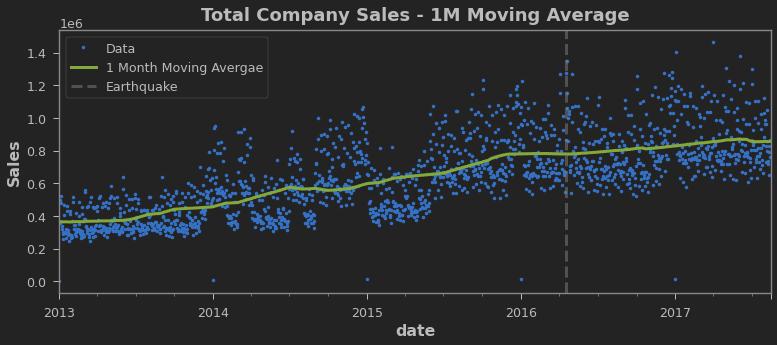

In [24]:
# capture daily sales sum over all stores & departments
sales_eda_target_daily = sales_eda_target.sales.groupby(['date']).sum()

# capture 1Y rolling average
sales_eda_target_mavg = sales_eda_target_daily.rolling(
    window=365, min_periods=180, center=True).mean()

# plot original data, trend and earthquake
ax = sales_eda_target_daily.plot(style='.', ms=7, label='Data', ylabel='Sales')
ax = sales_eda_target_mavg.plot(linewidth=3, label='1 Month Moving Avergae',
                   title='Total Company Sales - 1M Moving Average')
earthquake_plot()
_ = ax.legend()

Total sales volume has increased roughly 100% within 4.5 years. Sudden flattening in the end is caused by 2017 being represented only by half a years worth of data.

#### Store Operation Dur

In [25]:
# convert datetime index to periodindex
sales_eda_store_oper = sales_eda.groupby(['store_nbr', 'date']).sales.sum().to_frame()
sales_eda_store_oper.head(2)

sales
store_nbr date                
1         2013-01-01     0.000
          2013-01-02  7417.148

In [26]:
# number of different stores
n_stores = sales_eda_store_oper.index.get_level_values('store_nbr').nunique()
print(f"Number of different stores: {n_stores}")

Number of different stores: 54


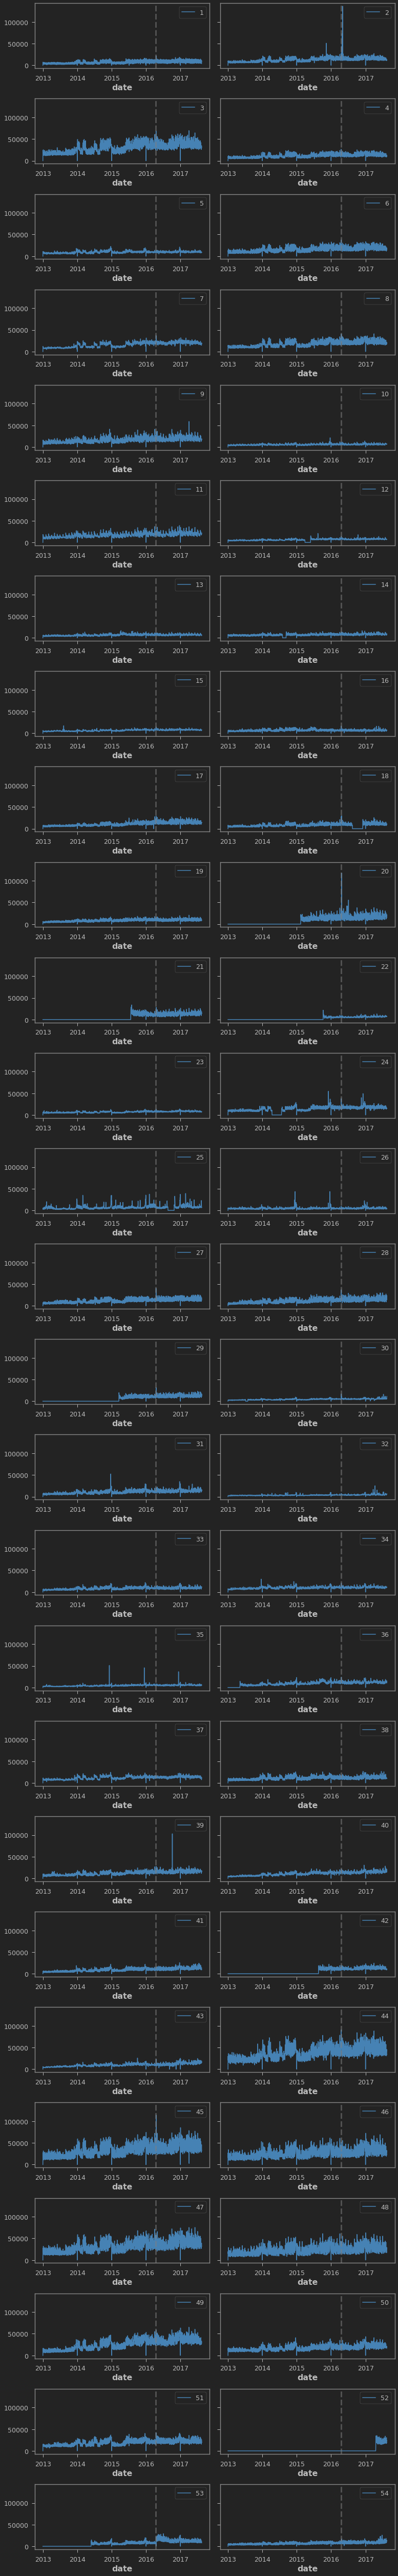

In [27]:
# plot each store operation intervals
axes = sales_eda_store_oper.unstack('store_nbr')['sales'].plot(
    subplots=True, figsize=(11, 70), sharex=False, sharey=True, 
    xlabel=None, layout=(27, 2), color='steelblue')

# capture earthquake on time line
for ax in axes.ravel():
    ax.axvline(x=pd.to_datetime("2016-04-16"), color='grey', 
                    linestyle='--', linewidth=3, alpha=0.5, 
                    label='Earthquake')
plt.show()

There are 5 stores that have operated only half of the time during 2013 - 2018. It seems earthquake impacted some store sales significantly.

#### Seasonality

##### Weekly
Try to see seasonality indicators on weekly basis for each year for all stores.

In [28]:
# sort data by store - family - date
sales_eda_sort = sales_eda.reset_index().set_index(
    ['store_nbr', 'family', 'date']).sort_index()
sales_eda_sort

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

In [29]:
# avergae sales grouped by date across departments and stores
avg_sales_eda = (sales_eda_sort
                 .groupby('date').mean()
                 .sales).to_frame()

avg_sales_eda.head(2)

sales
date                  
2013-01-01    1.409438
2013-01-02  278.390807

In [30]:
# add year, week and day columns
avg_sales_eda['year'] = avg_sales_eda.index.year
avg_sales_eda['week'] = avg_sales_eda.index.week
avg_sales_eda['dayofweek'] = avg_sales_eda.index.dayofweek

In [31]:
# sort data by year and date
avg_sales_eda_sort = avg_sales_eda.reset_index().set_index(['year', 'date'])
avg_sales_eda_sort.head(2)

sales  week  dayofweek
year date                                   
2013 2013-01-01    1.409438     1          1
     2013-01-02  278.390807     1          2

In [32]:
n_years = avg_sales_eda_sort.index.get_level_values('year').nunique()
print(f"Number of different stores: {n_years}")

Number of different stores: 5


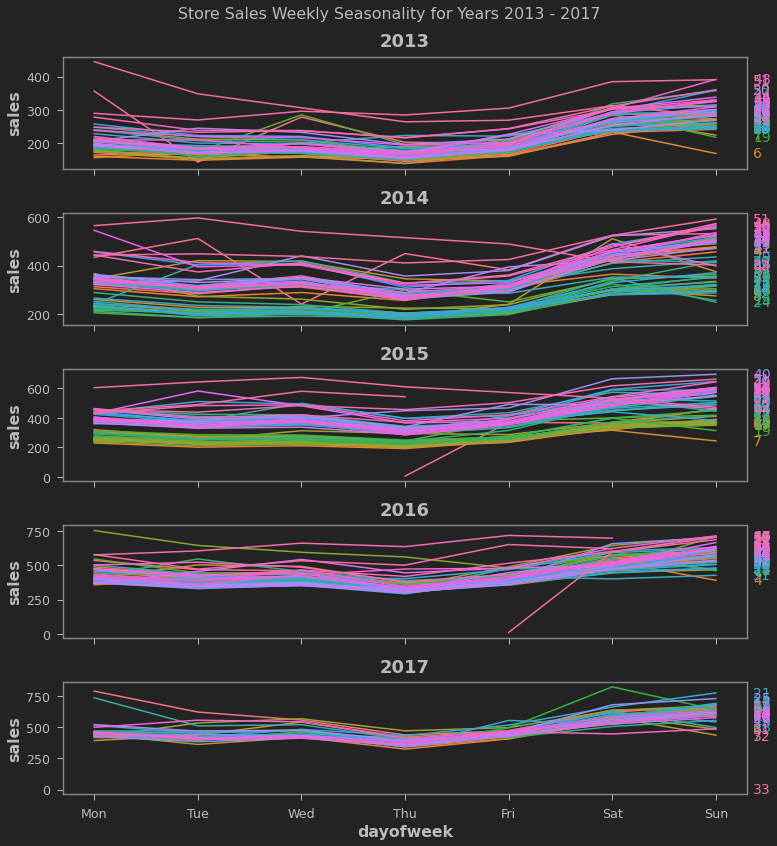

In [33]:
# plot each store operation intervals
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(11, 12))
fig.suptitle('Store Sales Weekly Seasonality for Years 2013 - 2017')

for ax,year in zip(axes.ravel(), np.arange(2013, 2018)):
    ax = seasonal_plot(df=avg_sales_eda_sort.loc[year], y='sales', 
                       period='week', freq='dayofweek', ax=ax)
    _ = ax.set_title(year)
    
# day of week labels
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[-1].set_xticks(np.arange(0,7), day_labels)
plt.show()

There's definitely seasonality indicators present in the data weekly charts. Now lets examine other possible longer term seasons.

In [34]:
avg_sales_eda_sort.loc[2013].sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Name: sales, dtype: float64

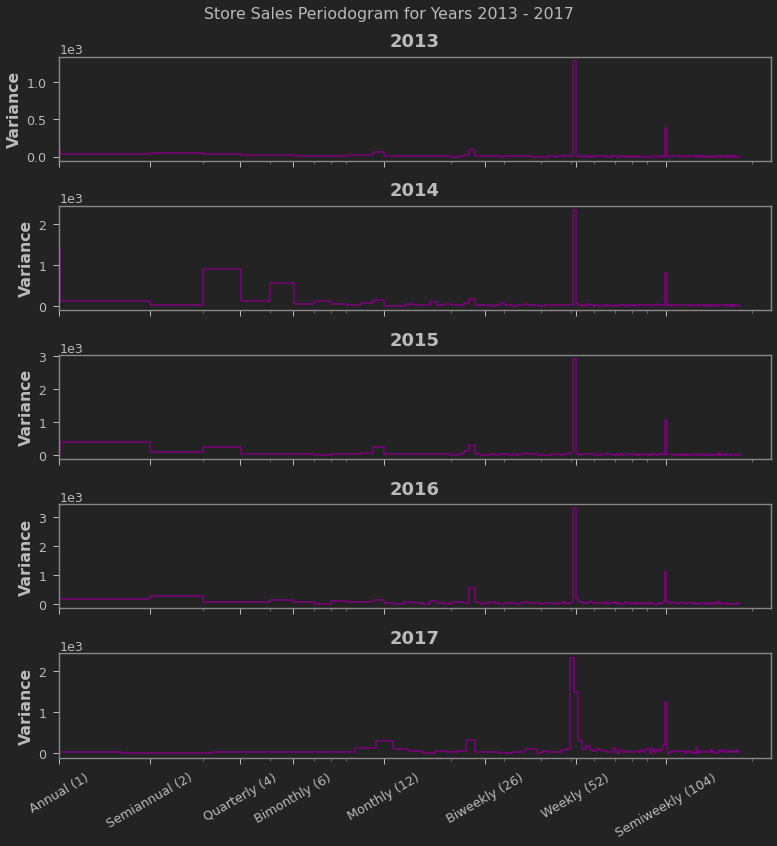

In [35]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(11, 12))
fig.suptitle('Store Sales Periodogram for Years 2013 - 2017')

for ax,year in zip(axes.ravel(), np.arange(2013, 2018)):
    ax = plot_periodogram(ts=avg_sales_eda_sort.loc[year].sales, ax=ax)
    _ = ax.set_title(year)
plt.show()

We can deduce that there's consistently Monthly and Biweekly seasonalities in the data. Therefore 4 Fourier features added to our model to capture it. We have outlying semiannual and quarterly seasonality for a year or two but they are not significant enough.

#### De-seasonalize
Let's remove seasons from the data and see what we have left.

In [36]:
temp = avg_sales_eda_sort.reset_index()
temp['date'] = temp.date.dt.to_period('D')
avg_sales_eda_sort = temp.set_index(['year', 'date'])
avg_sales_eda_sort.head(2)

sales  week  dayofweek
year date                                   
2013 2013-01-01    1.409438     1          1
     2013-01-02  278.390807     1          2

In [37]:
# capture the target only for now - sales
y = avg_sales_eda_sort['sales']

# choose frequence by largest seasonality which is month
# order by number of peaks * 2 on periodogram.
fourier = CalendarFourier(freq='M', order=4)

# init empty series
y_preds = pd.Series(dtype='O')

# loop through all years
for year in y.index.unique(level=0):
    
    # class for deterministic terms
    dp = DeterministicProcess(index=y[year].index,
                              constant=True,
                              order=1,
                              seasonal=True,
                              additional_terms=[fourier], 
                              drop=True)
    
    # capture seasonal data -> DF
    X = dp.in_sample()
    
    # create simple LR model
    model = LinearRegression().fit(X, y[year])
    y_pred = pd.Series(model.predict(X), index=X.index)
    y_preds = pd.concat([y_preds, y_pred], axis='index') 

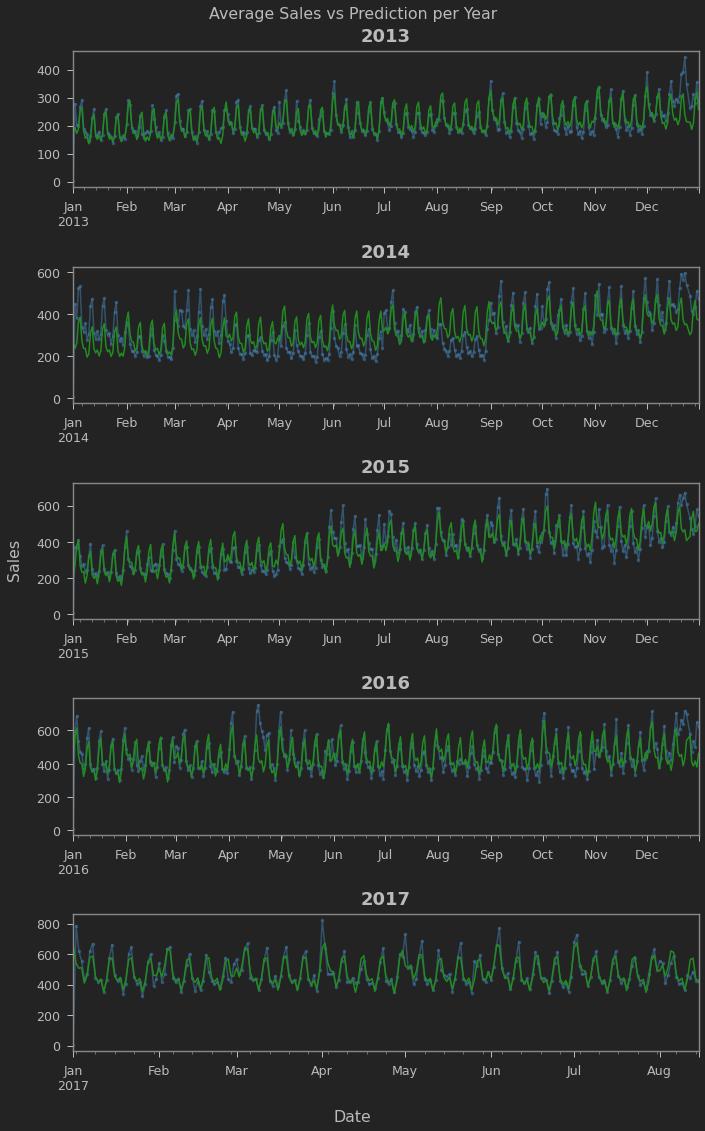

In [38]:
# plot predictions onto actual data
fig, axes = plt.subplots(nrows=len(y.index.unique(level=0)), ncols=1,
                         figsize=(10,16))

for ax,year in zip(axes, y.index.unique(level=0)):
    y[year].plot(alpha=0.5, style='.-', ms=7, color='steelblue', ax=ax)
    y_preds.loc[f"{year}"].plot(ax=ax, label='Prediciton', color='forestgreen')
    _ = ax.set_title(year)
    _ = ax.set_xlabel('')
    
plt.suptitle('Average Sales vs Prediction per Year')
fig.supylabel('Sales')
fig.supxlabel('Date')
plt.show()

We will remove seasons from original data

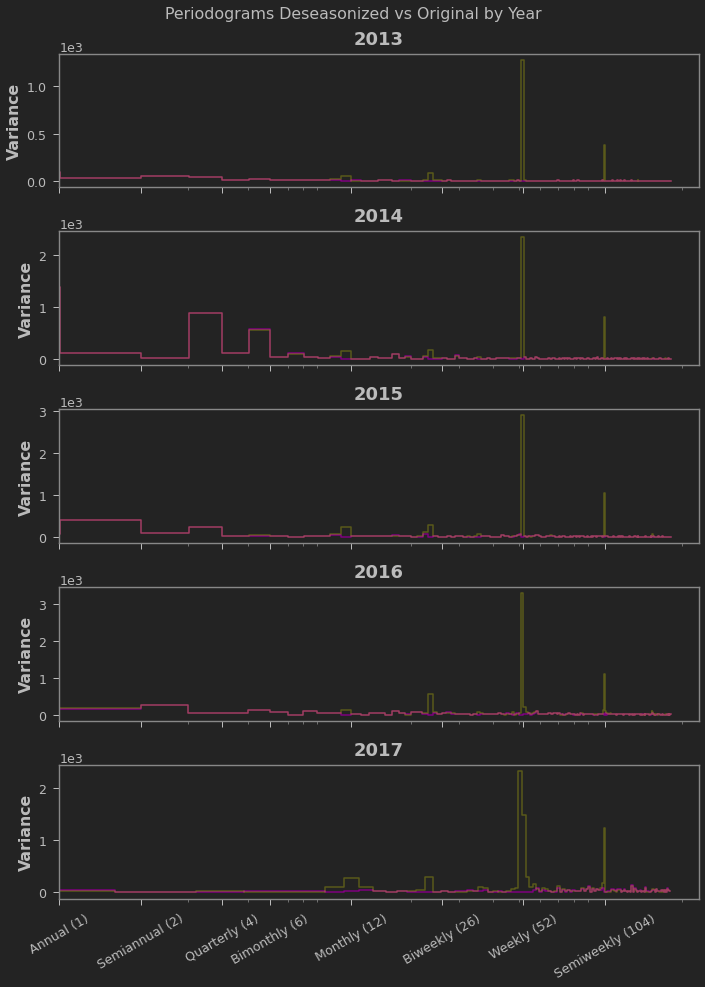

In [39]:
# deseasoned target values
y_des = y.reset_index('year').sales - y_preds

# plot deseasoned data onto original
fig, axes = plt.subplots(5, 1, figsize=(10,14), sharex=True)
plt.suptitle('Periodograms Deseasonized vs Original by Year')

for year,ax in zip(np.arange(2013,2018), axes):
    plot_periodogram(ts=y_des.loc[f"{year}"], ax=ax)
    plot_periodogram(ts=y[year], ax=ax, color='yellow', alpha=0.25)
    ax.set_title(f"{year}")
    
plt.show()

Seasonality is removed. Notice that 2014 has noticeable semi-annual seasonality but since it is 1/5 we consider it as an outlier.

#### Holidays
Let's see how holidays influence our charts. For that, we plot holidays on deseasoned data and see it's effect.

In [40]:
holidays.head(2)

type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False

In [41]:
holidays.type.value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [42]:
holidays.query("locale in ['National', 'Regional']").loc['2017']

type    locale                     locale_name  \
date                                                               
2017-01-01     Holiday  National                         Ecuador   
2017-01-02    Transfer  National                         Ecuador   
2017-02-27     Holiday  National                         Ecuador   
2017-02-28     Holiday  National                         Ecuador   
2017-04-01     Holiday  Regional                        Cotopaxi   
2017-04-14     Holiday  National                         Ecuador   
2017-05-01     Holiday  National                         Ecuador   
2017-05-13  Additional  National                         Ecuador   
2017-05-14       Event  National                         Ecuador   
2017-05-24     Holiday  National                         Ecuador   
2017-05-26    Transfer  National                         Ecuador   
2017-06-25     Holiday  Regional                        Imbabura   
2017-08-10     Holiday  National                         Ecuador   
2017-08-11    Transfer  National                         Ecuador   
2017-10-09     Holiday  National                         Ecuador   
2017-11-02     Holiday  National                         Ecuador   
2017-11-03     Holiday  National                         Ecuador   
2017-11-06     Holiday  Regional  Santo Domingo de los Tsachilas   
2017-11-07     Holiday  Regional                     Santa Elena   
2017-12-21  Additional  National                         Ecuador   
2017-12-22  Additional  National                         Ecuador   
2017-12-23  Additional  National                         Ecuador   
2017-12-24  Additional  National                         Ecuador   
2017-12-25     Holiday  National                         Ecuador   
2017-12-26  Additional  National                         Ecuador   

                                       description  transferred  
date                                                             
2017-01-01                      Primer dia del ano         True  
2017-01-02             Traslado Primer dia del ano        False  
2017-02-27                                Carnaval        False  
2017-02-28                                Carnaval        False  
2017-04-01           Provincializacion de Cotopaxi        False  
2017-04-14                           Viernes Santo        False  
2017-05-01                         Dia del Trabajo        False  
2017-05-13                       Dia de la Madre-1        False  
2017-05-14                         Dia de la Madre        False  
2017-05-24                    Batalla de Pichincha         True  
2017-05-26           Traslado Batalla de Pichincha        False  
2017-06-25           Provincializacion de Imbabura        False  
2017-08-10           Primer Grito de Independencia         True  
2017-08-11  Traslado Primer Grito de Independencia        False  
2017-10-09              Independencia de Guayaquil        False  
2017-11-02                         Dia de Difuntos        False  
2017-11-03                 Independencia de Cuenca        False  
2017-11-06      Provincializacion de Santo Domingo        False  
2017-11-07           Provincializacion Santa Elena        False  
2017-12-21                               Navidad-4        False  
2017-12-22                               Navidad-3        False  
2017-12-23                               Navidad-2        False  
2017-12-24                               Navidad-1        False  
2017-12-25                                 Navidad        False  
2017-12-26                               Navidad+1        False

In [43]:
# capture national holidays only
national_holidays = holidays.query(
    "locale in ['National', 'Regional'] & transferred == False")['description']

# if event or holidays share a date just use one event per date
national_holidays = national_holidays.groupby('date').first()

# convert periodindex to datetime
y_des.index = y_des.index.astype('datetime64[ns]')

# align the data so missing dates in y_des dont cause errors
y_des, national_holidays = y_des.align(national_holidays, join='left')

national_holidays = national_holidays.dropna()

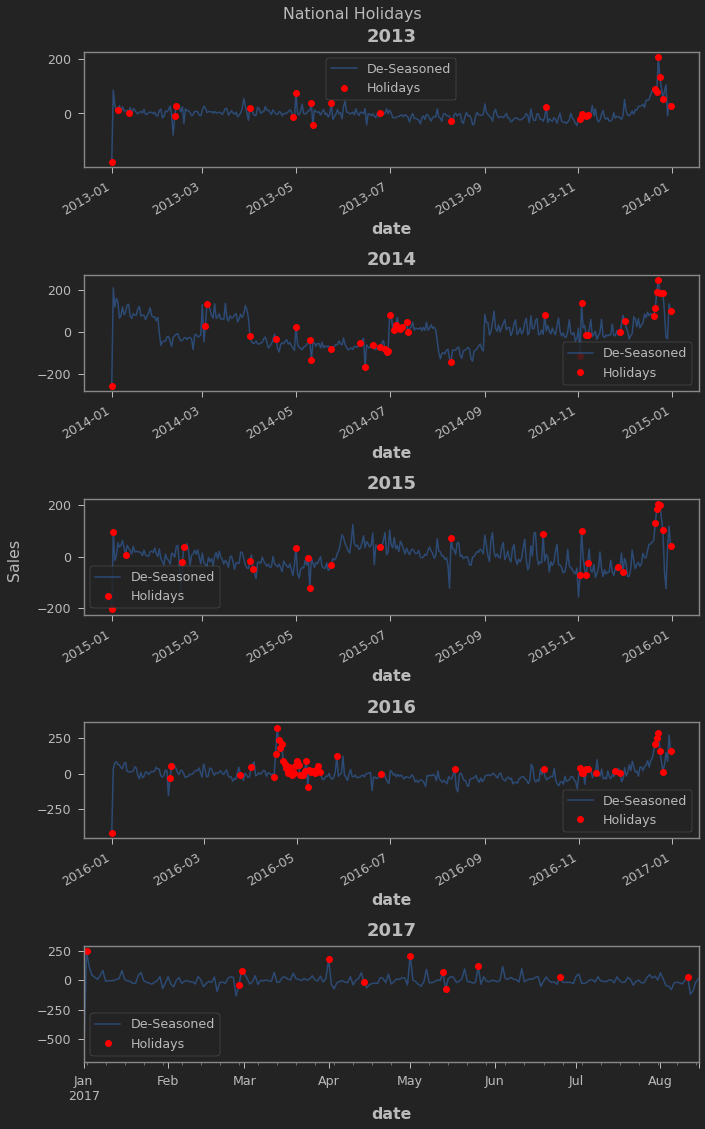

In [44]:
# plot deseasoned data and holidays
fig, axes = plt.subplots(5, 1, figsize=(10,16))
plt.suptitle('National Holidays')
fig.supylabel('Sales')

for ax, year in zip(axes, np.arange(2013, 2018)):
    y_des.loc[f"{year}"].plot(alpha=0.5, label='De-Seasoned', ax=ax)
    ax.plot_date(x=national_holidays.loc[f"{year}"].index, 
             y=y_des.loc[f"{year}"][national_holidays.loc[f"{year}"].index],
             color='red', label='Holidays')
    ax.set_title(f"{year}")
    ax.legend()
    
plt.show()

Holidays would predict some of the spikes on the data.

Instead of averaging over all departments, lets handle each department separately in given time frame.

In [45]:
sales_cyc = sales_eda.copy()
sales_cyc.index = sales_cyc.index.to_period('D') # index to period
sales_cyc.head(2)

id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0

In [46]:
# index data by store, family and date and sort 
sales_cyc = sales_cyc.reset_index().set_index(
    ['store_nbr', 'family', 'date']).sort_index()
sales_cyc.head(2)

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0            0
                     2013-01-02  1782    2.0            0

In [47]:
# group data by family and date, take a mean of all stores and unstack
# to set families as features
fam_sales = (
    sales_cyc
    .groupby(['family', 'date']).mean()
    .unstack('family')
    .loc[:, ['sales', 'onpromotion']]
)
fam_sales.head(2)

sales                                                      \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES BOOKS BREAD/BAKERY   
date                                                                        
2013-01-01   0.000000       0.0  0.037037    15.000000   0.0     3.344241   
2013-01-02   4.722222       0.0  3.833333  1335.037037   0.0   486.042944   

                                                             ... onpromotion  \
family     CELEBRATION     CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                         ...               
2013-01-01         0.0     3.444444    2.648148    1.316481  ...         0.0   
2013-01-02         0.0  1382.018519  432.981481  291.750000  ...         0.0   

                                                                             \
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2013-01-01   0.0           0.0          0.0                     0.0     0.0   
2013-01-02   0.0           0.0          0.0                     0.0     0.0   

                                                                      
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  

[2 rows x 66 columns]

Capture sales behaviour (possible cycles) of all families for 2016-08-15 - 2017-08-15

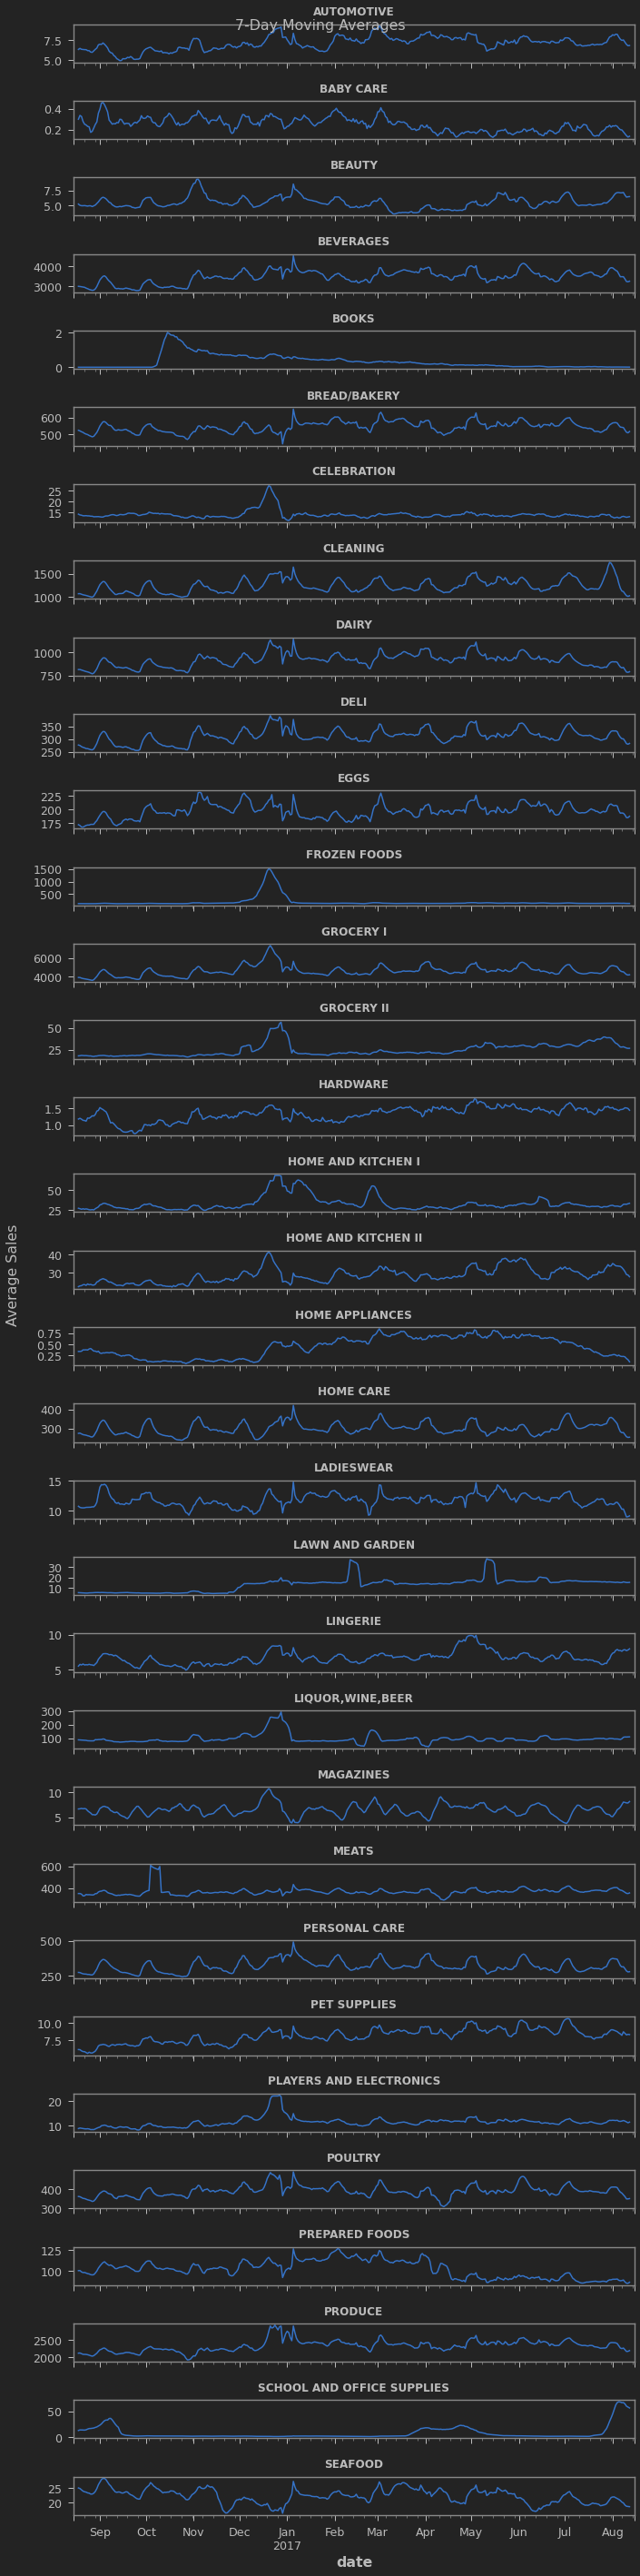

In [48]:
# select dates 2016-08-15 till 2017-08-15, and sales data
fam_sales1617 = fam_sales.loc['2016-08-15':, 'sales']

# let's see how each family performed within weekly average to
# smoothen out weekly seasonality
fig, axes = plt.subplots(nrows=fam_sales1617.columns.shape[0], ncols=1,
                         figsize=(10, 40), sharex=True)

for family,ax in zip(fam_sales1617.columns, axes):
    fam_ma = fam_sales1617[family].rolling(window=7, center=True).mean()
    fam_ma.plot(ax=ax)
    ax.set_title(family, fontsize=12)
    
plt.suptitle('7-Day Moving Averages')
fig.supylabel('Average Sales')
plt.show()

From the plot above we can see that Books, Frozen Food, School and Office Supplie familys have intrinsic cyclic behaviour. Lets deseasonalize data and plot sales by family.

In [49]:
# target
y_cyc = fam_sales1617

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y_cyc.index,
    constant=True,
    seasonal=True,
    order=1,
    drop=True,
    additional_terms=[fourier]
)

# capture X values
X_cyc = dp.in_sample()

# include new years day
X_cyc['NewYearsDay'] = (X_cyc.index.dayofyear == 1)

# init simple model
model = LinearRegression(fit_intercept=False).fit(X_cyc, y_cyc)
y_cyc_pred = pd.DataFrame(model.predict(X_cyc), index=X_cyc.index, 
                          columns=y_cyc.columns)
# deseasond data
y_cyc_de = y_cyc - y_cyc_pred
y_cyc_de.head(2)

family      AUTOMOTIVE  BABY CARE    BEAUTY   BEVERAGES     BOOKS  \
date                                                                
2016-08-15    0.350591  -0.113858  1.185030  225.102790 -0.691042   
2016-08-16    1.206532  -0.038489  0.739154  104.783631 -0.637950   

family      BREAD/BAKERY  CELEBRATION    CLEANING      DAIRY       DELI  ...  \
date                                                                     ...   
2016-08-15     53.058529     1.961541  134.396118  39.483182  32.036553  ...   
2016-08-16     32.451379    -0.587461  119.647840 -41.358019  33.848281  ...   

family      MAGAZINES      MEATS  PERSONAL CARE  PET SUPPLIES  \
date                                                            
2016-08-15   0.319168   9.698519      20.701521      0.937846   
2016-08-16   0.705580  27.002670      24.416203      0.790566   

family      PLAYERS AND ELECTRONICS    POULTRY  PREPARED FOODS     PRODUCE  \
date                                                                         
2016-08-15                -0.736430  24.434728       -7.949386  -50.428774   
2016-08-16                 0.073376  64.449370       -5.795655 -326.366581   

family      SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                              
2016-08-15                    6.709666  3.884621  
2016-08-16                   13.154655  2.103897  

[2 rows x 33 columns]

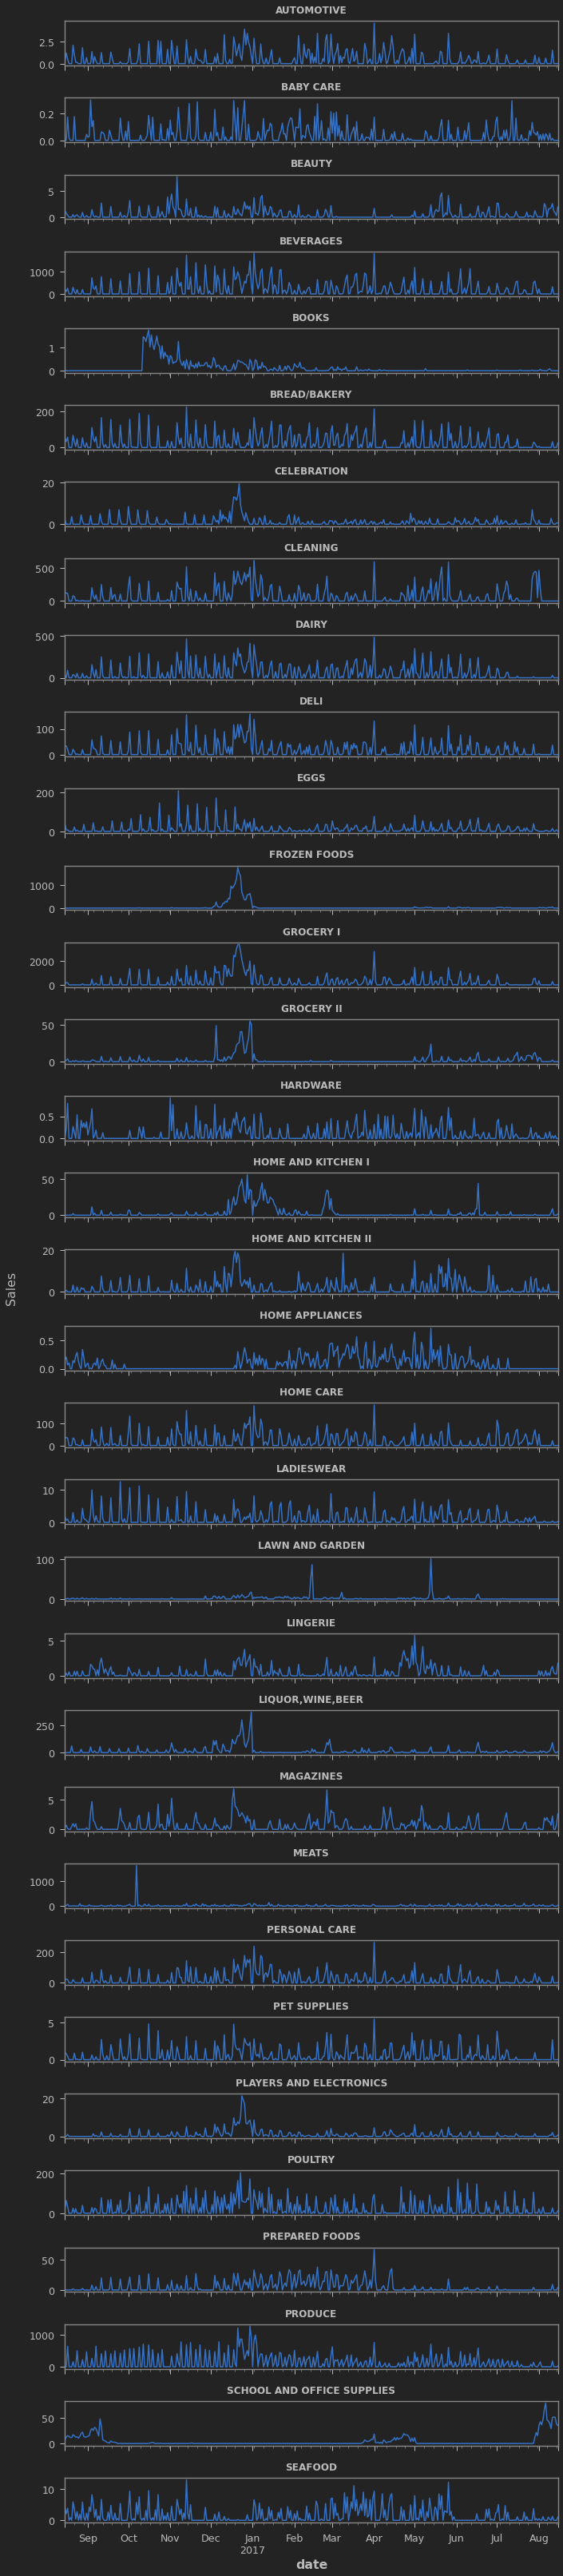

In [50]:
# let's see how each family performed within weekly average to
# smoothen out weekly seasonality
fig, axes = plt.subplots(nrows=y_cyc_de.columns.shape[0], ncols=1,
                         figsize=(10, 45), sharex=True)

for family,ax in zip(y_cyc_de.columns, axes):
    y_cyc_de[family].clip(0.).plot(ax=ax)
    ax.set_title(family, fontsize=12)
    
fig.supylabel('Sales')
plt.show()

Things to investigate:
* 1 peak in MEATS graphic. Explore on which date it is.
* 2 peaks in LAWN AND GARDEN
* Cycles in SCHOOL AND OFFICE SUPPLIES, BOOKS

Let's plot interesting holidays onto deseasoned data:

In [51]:
# our data spawn
sdate = '2016-08-15'
edate = '2017-08-15'
hols_1617 = holidays.loc[sdate:edate]

# capture only national and regional not transferred holidays
hols_1617 = hols_1617.query(
    "locale in ['National', 'Regional'] & transferred == False")

print(f"Number of holidays: {hols_1617.shape[0]}")

# convert index to period
hols_1617.index = hols_1617.index.to_period('D')

# remove Dec 25th as its not in the data
hols_1617 = hols_1617.drop('2016-12-25', axis='index')

Number of holidays: 27


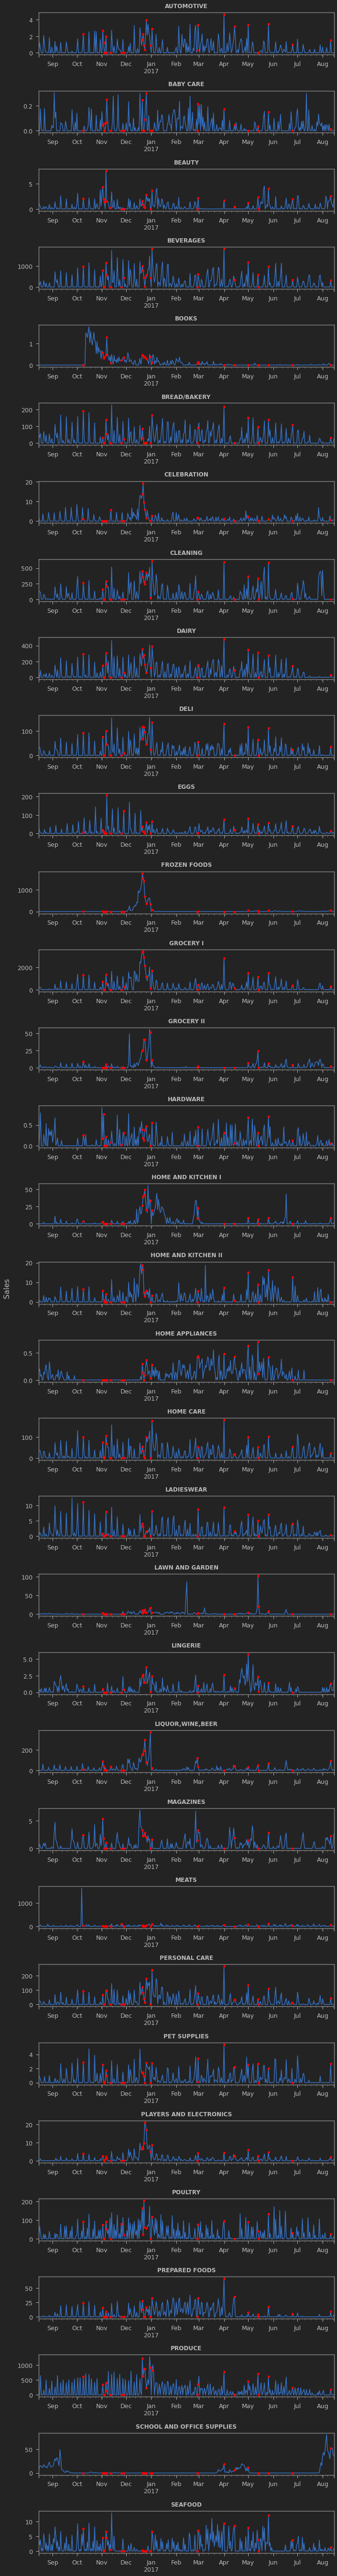

In [53]:
# let's see how each family performed within weekly average to
# smoothen out weekly seasonality dates plotted on top
fig, axes = plt.subplots(nrows=y_cyc_de.columns.shape[0], ncols=1,
                         figsize=(10, 75))

for family,ax in zip(y_cyc_de.columns, axes):
    y_cyc_de[family].clip(0.).plot(ax=ax, xlabel=None)
    ax.plot_date(x=hols_1617.index, 
                 y=y_cyc_de[family][hols_1617.index].clip(0.),
                 color='red', label='Holidays', markersize=5)
    ax.set_xlabel(None)
    ax.set_title(family, fontsize=12)
    
fig.supylabel('Sales')
plt.show()

* 2nd peak in LAWN ADN GARDEN described by Dia de la Madre holiday
* Peak in MEATS by preceeding day to Independencia de Guayaquil	holiday
* BOOK and SCHOOL AND OFFICE SUPPLIES sales not explained by holidays.

#### Cycles
With cycles we are trying to capture change in value rather than change in time.

Let's take a closer look at BOOK & SCHOOL AND OFFICE SUPPLIES sales through lag features, which should capture changing conditions dynamically rather than beign constriained to exact dates. More specifically lets inspect partial correlations between lags, which should show relative new information by each lag.

In [54]:
# school nad office supplies
so_supplies = 'SCHOOL AND OFFICE SUPPLIES'

In [55]:
# plot current SCHOOL AND OFFICE SUPPLIES predictions onto data
ax = fam_sales1617[so_supplies].plot(title=f"Average {so_supplies} Sales",
                                     label='data', ylabel='Items sold')
ax = y_cyc_de[so_supplies].clip(0.).plot(ax=ax, label='Deseasonalized Prediction')y_so_de1617
_ = ax.legend()

SyntaxError: invalid syntax (377667039.py, line 4)

In [ ]:
# lets see if lag features would help
_ = plot_pacf(x=y_cyc_de[so_supplies], lags=10, zero=False)

Seems like lags 1 and 8 might be significant on the correlogram. Lets see what kind of trend it is showing by correlating lags to each other.

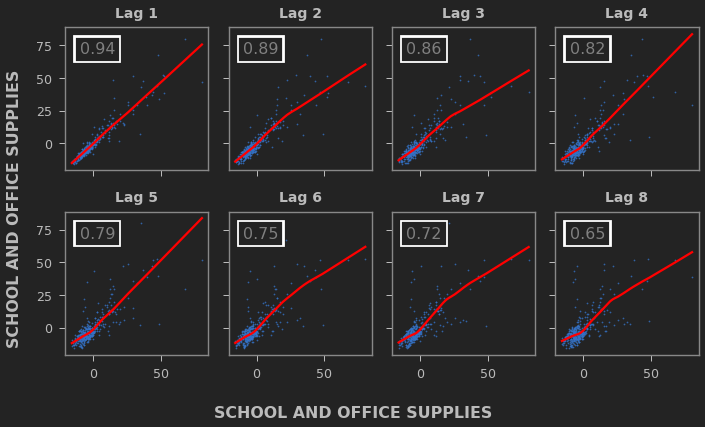

In [56]:
_ = plot_lags(x=y_cyc_de[so_supplies], lags=8, nrows=2, figsize=(10,6))

Seems to be linear trend. 
Now, we need some kind of feature that we can actually use a lag of. It makes sense to use "onpromotion" feature since promotions are known in advance by the company. Also, since already passed promotions might have influence on the sales we can create leading lag features as well.

In [57]:
# capture sales in office supply family 
so_sales1617 = fam_sales.loc[sdate:edate, 
    [('sales', so_supplies), ('onpromotion', so_supplies)]]
so_sales1617.head(2y_so_de1617)

SyntaxError: invalid syntax (1426564002.py, line 4)

In [ ]:
# capture onpromotion into series and rename
y_so_de1617 = so_sales1617.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

print(f"N days total: {so_onpromo.shape[0]}")

# drop days without prmotion
is_promo = so_onpromo[so_onpromo > 1]
print(f"N days with promotions: {is_promo.shape[0]}")

In [ ]:
# plot lags & leads to see correlation of onpromotion
_ = plot_lags(x=is_promo, y=y_cyc_de[so_supplies][so_onpromo > 1], lags=3, leads=3)

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

In [ ]:
y_so_de1617 = y_cyc_de[so_supplies]
y_so_de1617.head(2)

In [ ]:
so_promo1617 y_so_de1617= so_sales1617.loc[:, ('onpromotion', so_supplies)]
so_promo1617.head(2)

In [ ]:
# create lag1 by shifting sale values forward by 1 day
X_so_sales_lags = make_lags(ts=y_so_de1617, lags=1)

# create lead1 and lag1 by shifting onpromotion values
# and concat it to onpromotion values ts
X_so_promo_lags = pd.concat([so_onpromo,
                             make_lags(so_onpromo, lags=2),
                             make_leads(so_onpromo, leads=2)], 
                            axis='columns')

# join features to deseasoned features
X_leading_indic = pd.concat([
    X_cyc,
    X_so_sales_lags,
    X_so_promo_lags
], axis='columns').dropna()

X_leading_indic.head(1)

In [ ]:
# check if target and features have same indices
print(f"Target and Features indices match:", 
      y_so_de1617.index.equals(X_leading_indic.index))

In [ ]:
# align the indices
y_so_de1617, X_leading_indic = y_so_de1617.align(X_leading_indic, join='inner')

print(f"Target and Features indices match:", 
      y_so_de1617.index.equals(X_leading_indic.index))

Let's test if lag features help to predict better:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_leading_indic, y_so_de1617.clip(0.), shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.)
y_pred = pd.Series(model.predict(X_val), index=X_val.index).clip(0.)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_val = mean_squared_log_error(y_val, y_pred) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_val:.5f}')

Plot how deseasoned data fitted with original data and how deseasoned + serialized data fits with original data.

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

# plot deseasoned only
fam_sales1617[so_supplies].plot(title=f"Average {so_supplies} Sales",
                                label='data', ylabel='Items sold', ax=ax1)
y_cyc_de[so_supplies].clip(0.).plot(ax=ax1, label='Deseasonalized Prediction')
_ = ax1.legend()
_ = ax1.set_title(f"Without Leading Indicators")

# plot deseasoned + serialized
fam_sales1617[so_supplies].plot(title=f"Average {so_supplies} Sales",
                                label='data', ylabel='Items sold', ax=ax2)
y_fit.plot(label='Fit', ax=ax2)
y_pred.plot(label='Predict', ax=ax2)
_ = ax2.legend()
_ = ax2.set_title(f"With Leading Indicators")

plt.suptitle(f"Average {so_supplies} Sales")
plt.show()

### Features

#### Oil
In essence we try to capture best correlation between sales and oil price. We will check if:
 * oil price correlates to the price the same day
 * the following day
 * in 2 weeks

In [ ]:
# subset of 2016-08-15 : 2017-08-15 oil prices
oil1617 = oil.loc[sdate:edate]
oil1617.info()

Inspect NaN values

In [ ]:
# dates when oil has missing values
oil1617_nan = oil1617[oil1617.isna().dcoilwtico]

# add if it is weekend
oil1617_nan['weekend'] = oil1617_nan.index.dayofweek > 4

# add holidays to nan if excists
oil_hols = oil1617_nan.merge(holidays.loc[sdate:edate],
                             how='left', left_index=True,
                             right_index=True)
# drop duplicate indices
oil_hols = oil_hols[~oil_hols.index.duplicated(keep='first')]
oil_hols

10 days have missing values, some of them due to holidays but others are not explainable. Let's plot unexplainable days when daily gas price was not available onto deseasoned data.

In [ ]:
oil_hols[oil_hols.type.isna()]

In [ ]:
oil_hols_nan = oil_hols[oil_hols.type.isna()]
oil_hols_nan.index = oil_hols_nan.index.to_period('D')

fig, axes = plt.subplots(nrows=y_cyc_de.columns.shape[0], ncols=1,
                         figsize=(10, 60), sharex=True)

for family,ax in zip(y_cyc_de.columns, axes):
    y_cyc_de[family].clip(0.).plot(ax=ax)
    ax.plot_date(x=oil_hols_nan.index, 
                 y=y_cyc_de[family][oil_hols_nan.index].clip(0.),
                 color='red', label='Oil NaN', markersize=5)
    ax.set_title(family, fontsize=12)
    
fig.supylabel('Sales')
plt.show()

On these days the sales are mostly down it seems. Lets investigate if thats true for all original NaN days.

In [ ]:
oil1617_nan_2 = oil1617_nan.copy()
oil1617_nan_2.index = oil1617_nan_2.index.to_period('D')

fig, axes = plt.subplots(nrows=y_cyc_de.columns.shape[0], ncols=1,
                         figsize=(10, 60), sharex=True)

for family,ax in zip(y_cyc_de.columns, axes):
    y_cyc_de[family].clip(0.).plot(ax=ax)
    ax.plot_date(x=oil1617_nan_2.index, 
                 y=y_cyc_de[family][oil1617_nan_2.index].clip(0.),
                 color='red', label='All Oil NaN', markersize=5)
    ax.set_title(family, fontsize=12)
    
fig.supylabel('Sales')
plt.show()

Days when NaN oil prices were correlated with some of the holidays the sales show positive trend. Lets investigate Oil price on sales data

In [ ]:
# create a copy of oil
oil_clean = oil.copy()

# rename field name
oil_clean = oil_clean.rename({'dcoilwtico':'daily_price'}, axis='columns')

# capture oil dates 2016-08-13:
oil_clean = oil_clean.loc['2016-08-12':]

oil_clean.shape[0]

We have weekends missing in the data. Therefore lets fill in the missing gaps and forwarddill nans.

In [ ]:
# fill missing dates and fill missing values
oil_clean = oil_clean.asfreq('D').fillna(method='ffill')

# create new feature
oil_clean['price_change'] = oil_clean.loc[:, 'daily_price'].diff(1)

# remove christma day
oil_clean = oil_clean.drop('2016-12-25', axis='index')

# capture data where we need it
oil1617_clean = oil_clean.loc[sdate:edate]

print(f"NaN-s: {oil1617_clean.isna().sum()}")

In [ ]:
# see if the target and features are of same shape
oil1617_clean.shape[0] == y_cyc_de.shape[0]

In [ ]:
oil1617_clean.describe()

In [ ]:
# normalizing data
normalizer = MinMaxScaler()
y_cyc_de_normed = pd.DataFrame(normalizer.fit_transform(y_cyc_de.clip(0.)), 
                               index=y_cyc_de.index,
                               columns=y_cyc_de.columns)
oil1617_normed = pd.DataFrame(normalizer.fit_transform(oil1617_clean), 
                              index=oil1617_clean.index,
                              columns=oil1617_clean.columns)

In [ ]:
# plot normalized changes onto same plots
fig, axes = plt.subplots(nrows=y_cyc_de.columns.shape[0], ncols=1,
                         figsize=(10, 60), sharex=True)

for family,ax in zip(y_cyc_de.columns, axes):
    y_cyc_de_normed[family].plot(ax=ax)
    oil1617_normed.price_change.plot(ax=ax)
    
    ax.set_title(family, fontsize=12)

fig.supylabel('Sales')
plt.show()

From the graph is hard to tell how well oil price correlates with sales. Lets look at the correlation coefficients

In [ ]:
# create copys
y_cyc_de_oil = y_cyc_de.copy()
oil1617_clean_p = oil1617_clean.copy()

# convert index to period
oil1617_clean_p.index = oil1617_clean_p.index.to_period('D')

# merge two df-s
y_cyc_de_oil = y_cyc_de_oil.merge(oil1617_clean_p, how='left', 
                                  left_index=True, right_index=True)

print(f"NaN-s: {y_cyc_de_oil.isna().sum().sum()}")

In [ ]:
y_cyc_de_oil.columns[:]

In [ ]:
y_cyc_de_oil.clip(0.).corr()[['daily_price', 'price_change']]

In [ ]:
# total sales
y_de_tot = y_cyc_de.clip(0.).copy()
y_de_tot = y_de_tot.stack('family').reset_index().groupby('date').sum()
y_de_tot.columns = ['sales']
y_de_tot.head(2)

In [ ]:
# create 15 lag features
y_de_tot_lags = make_lags(ts=y_de_tot.squeeze(), lags=15, lead_time=0)

# for simplicity cut data short so we have no NaN-s
y_de_tot_lags = y_de_tot_lags.iloc[14:, :]
y_de_tot_lags.isna().sum().sum()

In [ ]:
# merge oil price and price change into the charts
y_de_tot_lag_oil = y_de_tot_lags.merge(oil1617_clean_p, how='left', 
                                  left_index=True, right_index=True)

y_de_tot_lag_oil.corr()[['daily_price', 'price_change']]

Didnt find significant correlation. Let's try moving average oil price influence on sales.

In [ ]:
ma_oil = oil1617_clean.copy()

# capture weekly and bi-weekly average oil price features and check correlation
ma_oil['ma_oil_7'] = ma_oil['daily_price'].rolling(window=7).mean()
ma_oil['ma_oil_14'] = ma_oil['daily_price'].rolling(window=14).mean()
ma_oil = ma_oil.dropna()
ma_oil.index  = ma_oil.index.to_period('D')
ma_oil.isna().sum().sum()

In [ ]:
y_de_tot.index.dtype

In [ ]:
y_de_ma = ma_oil.merge(y_de_tot, how='left', left_index=True, right_index=True)
y_de_ma.corr()[['sales']]

Lets plot moving average oil prices on each department.

In [ ]:
# normalize data
scaler = MinMaxScaler()
ma_oil2 = pd.DataFrame(scaler.fit_transform(ma_oil),
                       index=ma_oil.index, columns=ma_oil.columns)

# plot moving avergae oil prices onto each department sales
fig, axes = plt.subplots(nrows=y_cyc_de.columns.shape[0], ncols=1,
                         figsize=(10, 60), sharex=True)

for family,ax in zip(y_cyc_de.columns, axes):
    y_cyc_de_normed[family].clip(0.).plot(ax=ax)
    ma_oil2['ma_oil_7'].plot(ax=ax, label='ma_7')
    ma_oil2['ma_oil_14'].plot(ax=ax, label='ma_14')
    
    ax.set_title(family, fontsize=12)
    ax.legend(loc='upper left')
    
fig.supylabel('Sales')
plt.show()

7 day oil price moving avergae might be useful feature

# Delete Unused variables

In [106]:
# # select variables to delete
# #print([i for i in locals().keys() if not i.startswith('_')])
# unused_vars = [temp, sales_eda_target, sales_eda_target_daily, 
#                sales_eda_target_mavg, ax, sales_eda_store_oper, 
#                n_stores, axes, sales_eda_sort, avg_sales_eda, 
#                avg_sales_eda_sort, n_years, fig, year, day_labels, 
#                y, fourier, y_preds, dp, X, model, y_pred, 
#                y_des, national_holidays, sales_cyc, fam_sales, 
#                family, fam_ma, sdate, 
#                edate, so_supplies,
#                ma_oil, scaler, 
#                y_cyc_pred, hols_bok, new_y, figs, col, 
#                so_sales1617, so_onpromo, is_promo, 
#                so_promo1617, X_so_sales_lags, X_so_promo_lags, 
#                X_leading_indic, X_train, X_val, y_train, y_val, 
#                y_fit, rmsle_train, rmsle_val, oil1617, oil1617_nan, 
#                oil_hols, oil_hols_nan, oil1617_nan_2, normalizer, 
#                y_cyc_de_normed, oil1617_normed, y_cyc_de_oil, 
#                oil1617_clean_p, y_de_tot, y_de_tot_lags, 
#                y_de_tot_lag_oil, y_de_ma, a]

# # delete unused variables
# for var_ in unused_vars:
#     del var_

## Observations
1. <u>Trend</u>: 
    * Overall positive trend, the total sales has doubled from 2013 to 2018.
    * If we are going to use models like XGBoost we need to de-trend the data.
2. <u>Stores</u>: 
    * Some stores have limited sales history as they didn't excist before.
    * Create new feature "store_open" to capture if store actually worked that day or not.
3. <u>Seasonality</u>: 
    * Weekly seasonality, one-hot-encode 6 binary features off of that.
    * Monthly and bi-weekly seasonality present, capture it via 4 Fourier features with monthly frequency.
4. <u>Holidays</u>:
    * Include holidays that were actually celebrated that day, e.g. transferred == False.
5. <u>Cycles</u>: 
    * Families like SCHOOL AND OFFICE SUPPLIES and BOOKS seem to have cyclic behaviour.
6. <u>Leading Indicators</u>:
    * <code>onpromotion</code> - 1 lead and 1 lag on promotion and 1 lag on target when training the data.
7. <u>oil</u>:
    * 6 NaN-s in original data correspond to mostly 0 sales, which are not explained by holidays nor weekend days.
    * 7-day oil price moving average might be useful feature
8. <u>payday</u>: 
    * Include if it is a payday or not into the features.
9.

# PREPARE

In [3]:
sales_train = pd.read_csv('data/favorita_store_sales/train.csv', 
                         index_col='date', parse_dates=['date'])
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
# convert dtypes
train = sales_train.astype({'store_nbr': 'category',
                            'family': 'category'})
# change index to period
train.index = train.index.to_period('D')
train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 5 columns):
 #   Column       Dtype   
---  ------       -----   
 0   id           int64   
 1   store_nbr    category
 2   family       category
 3   sales        float64 
 4   onpromotion  int64   
dtypes: category(2), float64(1), int64(2)
memory usage: 97.3 MB


Capture start and end dates. Create new df "calendar"

In [5]:
# capture rough range for training data, we will narrow
# it down to '2016-08-15' : '2017-08-15'
sdate = '2016-07-15'
edate = '2017-08-31'

# create a training set "calendar"
calendar = pd.DataFrame(index=pd.date_range(start=sdate,
                                            end=edate,
                                            freq='D'))
calendar.index = calendar.index.to_period('D')
calendar.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 413 entries, 2016-07-15 to 2017-08-31
Freq: D
Empty DataFrame

In [6]:
# include day of week column 0:monday, 6:sunday
calendar['dow'] = calendar.index.dayofweek
calendar.head(2)

dow
2016-07-15    4
2016-07-16    5

In [7]:
# read in oil data
oil = pd.read_csv('data/favorita_store_sales/oil.csv', index_col='date',
                  parse_dates=['date'])
oil.index = oil.index.to_period('D')

# weekly average oil price
oil['ma_week_oil'] = oil['dcoilwtico'].rolling(window=7).mean()

# merge average oil price to calendar
calendar = calendar.merge(oil.loc[sdate:], how='left', left_index=True,
                          right_index=True)
calendar = calendar.fillna(method='ffill')

# missing values if any
print(f"Total NaN-s: {calendar.isna().sum().sum()}")
calendar = calendar.loc[sdate:edate]
calendar.head(2)

Total NaN-s: 0


dow  dcoilwtico  ma_week_oil
2016-07-15    4       45.93    45.511429
2016-07-16    5       45.93    45.511429

In [8]:
# holidays
holidays = pd.read_csv('data/favorita_store_sales/holidays_events.csv',
                       index_col='date', parse_dates=['date'])
holidays.index = holidays.index.to_period('D')
holidays.head(2)

type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False

In [9]:
# capture national holidays 2016-08 onwards
hols = holidays.loc[sdate:].query("locale == 'National'")

# if same day has multiple hols just select first
hols = hols.groupby('date').first()
hols['2017':].head(2)

type    locale locale_name                  description  \
date                                                                      
2017-01-01   Holiday  National     Ecuador           Primer dia del ano   
2017-01-02  Transfer  National     Ecuador  Traslado Primer dia del ano   

            transferred  
date                     
2017-01-01         True  
2017-01-02        False

In [10]:
# set new years transferred to False and keep only 
# holidays that were not transferred
hols.loc['2017-01-01', 'transferred'] = False
hols = hols.query("transferred == False")
hols.loc['2017':].head(2)

type    locale locale_name                  description  \
date                                                                      
2017-01-01   Holiday  National     Ecuador           Primer dia del ano   
2017-01-02  Transfer  National     Ecuador  Traslado Primer dia del ano   

            transferred  
date                     
2017-01-01        False  
2017-01-02        False

In [11]:
# create a new feature workday to calendar
calendar['wd'] = True                           # init all days as workdays
calendar.loc[calendar.dow > 4, 'wd'] = False    # weekends as not workdays

# merge holidays to calendar
calendar = calendar.merge(hols, how='left', left_index=True, right_index=True)
calendar.head(2)

dow  dcoilwtico  ma_week_oil     wd type locale locale_name  \
2016-07-15    4       45.93    45.511429   True  NaN    NaN         NaN   
2016-07-16    5       45.93    45.511429  False  NaN    NaN         NaN   

           description transferred  
2016-07-15         NaN         NaN  
2016-07-16         NaN         NaN

In [12]:
# modify workdays
calendar.query("type == 'Bridge'").wd = False
calendar.query("type == 'Work Day'").wd = True
calendar.query("type == 'Transfer'").wd = False
calendar.query("type == 'Holiday' & transferred == False").wd = False
calendar.head(2)

dow  dcoilwtico  ma_week_oil     wd type locale locale_name  \
2016-07-15    4       45.93    45.511429   True  NaN    NaN         NaN   
2016-07-16    5       45.93    45.511429  False  NaN    NaN         NaN   

           description transferred  
2016-07-15         NaN         NaN  
2016-07-16         NaN         NaN

In [13]:
# convert periodindex back to datetime
calendar.index = calendar.index.astype('datetime64[D]')

# find paydays index, last day of month and 15th
payday_mask = calendar[(calendar.index.day == 15) | 
                       (calendar.index.is_month_end)].index

# init all days as not paydays
calendar['public_payday'] = False
calendar.loc[payday_mask, 'public_payday'] = True
calendar.head(3)

dow  dcoilwtico  ma_week_oil     wd type locale locale_name  \
2016-07-15    4       45.93    45.511429   True  NaN    NaN         NaN   
2016-07-16    5       45.93    45.511429  False  NaN    NaN         NaN   
2016-07-17    6       45.93    45.511429  False  NaN    NaN         NaN   

           description transferred  public_payday  
2016-07-15         NaN         NaN           True  
2016-07-16         NaN         NaN          False  
2016-07-17         NaN         NaN          False

Find days the stores were open.

In [14]:
# train data from start date to end date
train_16 = train.loc[sdate:]

# group data by store and date total sales on each day
train_16 = train_16.reset_index().groupby(['store_nbr', 'date'])\
    .sales.sum().to_frame()

# find dates when each store was not operating, 
# eg sales == 0 across all families
stores_0_mask = train_16[train_16.sales == 0].index

# create column "store_open", True/False
train_16['store_open'] = True
train_16.loc[stores_0_mask, 'store_open'] = False
train_16.head(2)

sales  store_open
store_nbr date                             
1         2016-07-15  12075.518        True
          2016-07-16  11613.160        True

In [15]:
# cerate a copy of train
train_open = train.loc['2016-08-15':].copy()

# sort train data by store_nbr and date
train_open = train_open.reset_index().set_index(['store_nbr', 'date']).sort_index()

# merge store open days to training data
train_open = train_open.merge(train_16.store_open, how='left', 
                  left_index=True, right_index=True)

train_open = train_open.reset_index('store_nbr')
train_open.head(2)

store_nbr       id      family  sales  onpromotion  store_open
date                                                                      
2016-08-15          1  2350458  AUTOMOTIVE    4.0            0        True
2016-08-15          1  2350459   BABY CARE    0.0            0        True

In [16]:
# grab useful features from calendar
X_calendar = calendar.loc['2016-08-15':, 
            ['dow', 'ma_week_oil', 'wd', 'type', 'public_payday']]
X_calendar.index = X_calendar.index.to_period('D')

# merge useful features by date
X_feat = train_open.merge(X_calendar, how='left',
             left_index=True, right_index=True)
X_feat.head(2)

store_nbr       id      family  sales  onpromotion  store_open  \
2016-08-15          1  2350458  AUTOMOTIVE    4.0            0        True   
2016-08-15          1  2350459   BABY CARE    0.0            0        True   

            dow  ma_week_oil    wd type  public_payday  
2016-08-15    0    43.302857  True  NaN           True  
2016-08-15    0    43.302857  True  NaN           True

In [17]:
# convert type == NaN-s to ordinary day as they are not special days
X_feat.type.value_counts(dropna=False)

NaN           609444
Holiday        14256
Additional     12474
Event           5346
Transfer        5346
Bridge          1782
Work Day        1782
Name: type, dtype: int64

In [18]:
X_feat['type'] = X_feat.type.fillna('Ordinary Day')
X_feat.type.value_counts(dropna=False)

Ordinary Day    609444
Holiday          14256
Additional       12474
Event             5346
Transfer          5346
Bridge            1782
Work Day          1782
Name: type, dtype: int64

In [19]:
# check if we have more nans present in the data
X_feat.isna().sum().sum()

0

Preprocessing:
* label encode <code>dow</code> : day of week
* label encode <code>type</code> : type of day

In [20]:
# dummy encode 'dow' & 'type'
X_feat = pd.get_dummies(X_feat, columns=['dow'], drop_first=True)
X_feat = pd.get_dummies(X_feat, columns=['type'], drop_first=False)
X_feat.head(2)

store_nbr       id      family  sales  onpromotion  store_open  \
2016-08-15          1  2350458  AUTOMOTIVE    4.0            0        True   
2016-08-15          1  2350459   BABY CARE    0.0            0        True   

            ma_week_oil    wd  public_payday  dow_1  ...  dow_4  dow_5  dow_6  \
2016-08-15    43.302857  True           True      0  ...      0      0      0   
2016-08-15    43.302857  True           True      0  ...      0      0      0   

            type_Additional  type_Bridge  type_Event  type_Holiday  \
2016-08-15                0            0           0             0   
2016-08-15                0            0           0             0   

            type_Ordinary Day  type_Transfer  type_Work Day  
2016-08-15                  1              0              0  
2016-08-15                  1              0              0  

[2 rows x 22 columns]

In [21]:
# sort our df by store, family and date
df = X_feat.copy()
df.index.name = 'date'
df = df.reset_index().set_index(['store_nbr', 'family', 'date']).sort_index()
df.head(2)

id  sales  onpromotion  store_open  \
store_nbr family     date                                                  
1         AUTOMOTIVE 2016-08-15  2350458    4.0            0        True   
                     2016-08-16  2352240    5.0            0        True   

                                 ma_week_oil    wd  public_payday  dow_1  \
store_nbr family     date                                                  
1         AUTOMOTIVE 2016-08-15    43.302857  True           True      0   
                     2016-08-16    43.980000  True          False      1   

                                 dow_2  dow_3  dow_4  dow_5  dow_6  \
store_nbr family     date                                            
1         AUTOMOTIVE 2016-08-15      0      0      0      0      0   
                     2016-08-16      0      0      0      0      0   

                                 type_Additional  type_Bridge  type_Event  \
store_nbr family     date                                                   
1         AUTOMOTIVE 2016-08-15                0            0           0   
                     2016-08-16                0            0           0   

                                 type_Holiday  type_Ordinary Day  \
store_nbr family     date                                          
1         AUTOMOTIVE 2016-08-15             0                  1   
                     2016-08-16             0                  1   

                                 type_Transfer  type_Work Day  
store_nbr family     date                                      
1         AUTOMOTIVE 2016-08-15              0              0  
                     2016-08-16              0              0

## Simple Models
### Date related
Using only date related features.
Convert:
* Type NaN to Ordinary workday
* Dummy encode dow and type
* Standardize ma_week_oil

In [22]:
X_calendar.head(2)

dow  ma_week_oil    wd type  public_payday
2016-08-15    0    43.302857  True  NaN           True
2016-08-16    1    43.980000  True  NaN          False

In [23]:
X_cal = X_calendar.loc['2016-08-15':].copy()
X_cal.index.name = 'date'
# fill NaNs
X_cal['type'] = X_cal.type.fillna('Ordinary Day')

# Check N Nan-s
print(f'Total NaN-s: {X_cal.isna().sum().sum()}')

# standardize ma-week_oil
X_cal['ma_week_oil'] = PowerTransformer().fit_transform(
                       X_cal['ma_week_oil'].values.reshape(-1,1))
X_cal.head(2)

Total NaN-s: 0


dow  ma_week_oil    wd          type  public_payday
date                                                           
2016-08-15    0    -1.865034  True  Ordinary Day           True
2016-08-16    1    -1.625941  True  Ordinary Day          False

In [24]:
# dummy encode type and dow
X_cal = pd.get_dummies(X_cal, columns=['dow'], drop_first=True)
X_cal = pd.get_dummies(X_cal, columns=['type'], drop_first=False)
X_cal.head(2)

ma_week_oil    wd  public_payday  dow_1  dow_2  dow_3  dow_4  \
date                                                                       
2016-08-15    -1.865034  True           True      0      0      0      0   
2016-08-16    -1.625941  True          False      1      0      0      0   

            dow_5  dow_6  type_Additional  type_Bridge  type_Event  \
date                                                                 
2016-08-15      0      0                0            0           0   
2016-08-16      0      0                0            0           0   

            type_Holiday  type_Ordinary Day  type_Transfer  type_Work Day  
date                                                                       
2016-08-15             0                  1              0              0  
2016-08-16             0                  1              0              0

In [25]:
# select targets by store & date
y = df.sales.unstack(['store_nbr', 'family'])
y.head(2)

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2016-08-15        4.0       0.0    1.0    2420.0   0.0      502.555   
2016-08-16        5.0       0.0    5.0    2010.0   0.0      384.275   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2016-08-15        11.0    840.0  849.0  183.896  ...       0.0  68.205   
2016-08-16        22.0    626.0  717.0  152.010  ...       0.0  68.085   

store_nbr                                                                 \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2016-08-15         240.0          0.0                     3.0  20.111000   
2016-08-16         165.0          0.0                     1.0  81.087006   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2016-08-15          114.0  598.232                        0.0     5.0  
2016-08-16          120.0  818.567                        0.0     5.0  

[2 rows x 1782 columns]

In [26]:
# create seasonal features
fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(index=y.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          additional_terms=[fourier],
                          drop=True)
# seasonal features
X_season = dp.in_sample()

# merge seasonal and calendar featuresX_cal.loc[stest:etest]
X_date = X_season.merge(X_cal.loc[:'2017-08-15'], how='left', 
                        left_index=True, right_index=True)

print(f"Indices match: {y.index.equals(X_date.index)}")

Indices match: True


In [27]:
# create model
X_train, X_val, y_train, y_val = train_test_split(X_date, y, 
    test_size=0.25, shuffle=False)

model = LinearRegression(fit_intercept=False, n_jobs=-1)
model.fit(X_train,y_train)

y_fit = pd.DataFrame(model.predict(X_train), 
                     index=X_train.index,
                     columns=y.columns).clip(0.)
y_fore = pd.DataFrame(model.predict(X_val),
                      index=X_val.index,
                      columns=y.columns).clip(0.)

In [28]:
rmsle_train = mean_squared_log_error(y_true=y_train, y_pred=y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_val, y_fore) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.72345
Validation RMSLE: 0.76334


In [29]:
# inspect the results
y_pred = y_fore.stack(['store_nbr', 'family']).reset_index() \
         .rename({0:'sales'}, axis='columns')
y_target = y.loc[y_fore.index].stack(['store_nbr', 'family']) \
         .reset_index().copy().rename({0:'sales'}, axis='columns')
X_cal.loc[stest:etest]
# add predicted sales to target df
y_target['sales_pred'] = y_pred['sales']
y_target.head(2)

date  store_nbr      family  sales  sales_pred
0  2017-05-16          1  AUTOMOTIVE    3.0     3.89711
1  2017-05-16          1   BABY CARE    0.0     0.00000

Lets upload our first submission to Kaggle. Lets train our model on all of train data.

In [31]:
# test dates
stest = '2017-08-16'
etest = '2017-08-31'

X_test = dp.out_of_sample(steps=16) # test seasonality

# add calendar features to test
X_test = X_test.merge(X_cal.loc[stest:etest], how='left', 
                      left_index=True, right_index=True)
X_test.head(2)

const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
2017-08-16    1.0  366.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-17    1.0  367.0     0.0     1.0     0.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  ...  dow_4  dow_5  dow_6  \
2017-08-16       0.101168      -0.994869  ...      0      0      0   
2017-08-17      -0.101168      -0.994869  ...      0      0      0   

            type_Additional  type_Bridge  type_Event  type_Holiday  \
2017-08-16                0            0           0             0   
2017-08-17                0            0           0             0   

            type_Ordinary Day  type_Transfer  type_Work Day  
2017-08-16                  1              0              0  
2017-08-17                  1              0              0  

[2 rows x 32 columns]

In [32]:
# init model with entire train data
model = LinearRegression(fit_intercept=False, n_jobs=-1)
model.fit(X_date, y)

# capture predictions
sales_pred = pd.DataFrame(model.predict(X_test), 
                          index=X_test.index,
                          columns=y.columns)
sales_pred.head(2)

store_nbr          1                                                           \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   4.177433       0.0  3.517456  2568.601562  0.884415   423.755859   
2017-08-17   4.095745       0.0  2.701599  2226.640625  0.427216   372.623047   

store_nbr                                                   ...        54  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   14.982788  875.367188  889.410156  150.503906  ...  0.890533   
2017-08-17   19.032715  710.000000  738.199219  128.085938  ...  0.537796   

store_nbr                                                                 \
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  47.988159    155.990234     0.112509                2.977936   
2017-08-17  58.166626    136.000977     0.062639                2.834648   

store_nbr                                                                    \
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
2017-08-16  61.010742      83.242188  598.249023                   2.864471   
2017-08-17  61.626465      72.589355  545.960938                   2.154663   

store_nbr             
family       SEAFOOD  
2017-08-16  4.453735  
2017-08-17  3.188843  

[2 rows x 1782 columns]

In [33]:
sales_pred_stacked = sales_pred.stack(['store_nbr', 'family']).clip(0.)
sales_pred_stacked.head(2)

            store_nbr  family    
2017-08-16  1          AUTOMOTIVE    4.177433
                       BABY CARE     0.000000
dtype: float64

In [34]:
sales_test = pd.read_csv('data/favorita_store_sales/test.csv', 
                        index_col='date', parse_dates=['date'])
sales_test.head(2)

id  store_nbr      family  onpromotion
date                                                   
2017-08-16  3000888          1  AUTOMOTIVE            0
2017-08-16  3000889          1   BABY CARE            0

In [35]:
X_cal.loc[stest:etest], how='left', 
                      left_index=True, right_index=Truecalendar.loc['2017-08-16':]
df_sub = pd.DataFrame(
    {'id':sales_test.id.values,
     'sales': sales_pred_stacked.values}).set_index('id')

# write df to file
# df_sub.to_csv('submissions/favorita_store_sales/sub1.csv', index=True)
"""Root Mean Squared Logarithmic Error Score: 1.15289"""
df_sub.head(3)

sales
id               
3000888  4.177433
3000889  0.000000
3000890  3.517456

<code>FROZEN FOODS</code> and <code>SCHOOL AND OFFICE SUPPLIES</code> performed badly. As we already saw in EDA, these familys have cyclic sales pattern. As we showed, cycles can be captured by lag features. Best lag feature would be <code>onpromotion</code> since it is known in advnace by the comopany when promotions excists. 

### Store & Family related
We are going to capture each store and each family separately. We're also going to use <code>onpromotion</code> feature with it's lags.

In [36]:
df.head(2)

id  sales  onpromotion  store_open  \
store_nbr family     date                                                  
1         AUTOMOTIVE 2016-08-15  2350458    4.0            0        True   
                     2016-08-16  2352240    5.0            0        True   

                                 ma_week_oil    wd  public_payday  dow_1  \
store_nbr family     date                                                  
1         AUTOMOTIVE 2016-08-15    43.302857  True           True      0   
                     2016-08-16    43.980000  True          False      1   

                                 dow_2  dow_3  dow_4  dow_5  dow_6  \
store_nbr family     date                                            
1         AUTOMOTIVE 2016-08-15      0      0      0      0      0   
                     2016-08-16      0      0      0      0      0   

                                 type_Additional  type_Bridge  type_Event  \
store_nbr family     date                                                   
1         AUTOMOTIVE 2016-08-15                0            0           0   
                     2016-08-16                0            0           0   

                                 type_Holiday  type_Ordinary Day  \
store_nbr family     date                                          
1         AUTOMOTIVE 2016-08-15             0                  1   
                     2016-08-16             0                  1   

                                 type_Transfer  type_Work Day  
store_nbr family     date                                      
1         AUTOMOTIVE 2016-08-15              0              0  
                     2016-08-16              0              0

In [37]:
df.shape

(650430, 20)

We're going to write a function to train & predict results for each store and family separately and then concating everything together.

In [80]:
# split train and validation sets
df_train = (
    df.unstack(['store_nbr', 'family'])
    .loc['2016-08-15':'2017-05-14']
    .stack(['store_nbr', 'family'])
    .reorder_levels(['store_nbr', 'family', 'date'], axis='index'))

df_val = (
    df.unstack(['store_nbr', 'family'])
    .loc['2017-05-15':'2017-08-15']
    .stack(['store_nbr', 'family'])
    .reorder_levels(['store_nbr', 'family', 'date'], axis='index'))

print(f"Train + Val = DF: {df_train.shape[0] + df_val.shape[0] == df.shape[0]}")

Train + Val = DF: True


In [164]:
def train_predict(train_df, test_df, model, val_df=True):
    """Train on each store and each family separately. Concat
    respective results and predictions together."""
    
    # check if df have following indexing format: store, family date
    assert train_df.index.names == ['store_nbr', 'family', 'date'] and \
        test_df.index.names == ['store_nbr', 'family', 'date'], \
        "One or both DF-s wrongly indexed."
    
    # set name to features
    train_df.columns = train_df.columns.rename('features') 
    test_df.columns = test_df.columns.rename('features')
    
    # unstack store_nbr and family to columns
    train_df = train_df.unstack(['store_nbr', 'family'])
    test_df = test_df.unstack(['store_nbr', 'family'])
     
    # extract target sales and id
    y_train = train_df[['sales', 'id']]
    y_test = test_df[['sales', 'id']] if val_df else test_df['id']
    
    # init empty DF-s
    y_fit = pd.DataFrame(index=train_df.index, columns=y_train.columns)
    y_pred = pd.DataFrame(index=test_df.index, columns=y_train.columns)
    
    y_fit['id'] = y_train.id
    y_pred['id'] = test_df['id']
    
    # generate seasonal features
    fourier = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        index=y_train.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True)
    
    # seasonal features
    X_train_season = dp.in_sample()
    
    # n days to forecast
    n_days = test_df.reset_index().set_index('date').groupby('date').first().shape[0]
    X_test_season = dp.out_of_sample(steps=n_days)
    
    # normal features and reorder column levels
    X_train = train_df.drop(['id', 'sales'], axis='columns') \
        .reorder_levels(['store_nbr', 'family', 'features'], axis='columns')
    
    X_test = None
    if val_df:
        X_test = test_df.drop(['id', 'sales'], axis='columns') \
        .reorder_levels(['store_nbr', 'family', 'features'], axis='columns')  
    else:
        X_test = test_df.drop(['id'], axis='columns') \
        .reorder_levels(['store_nbr', 'family', 'features'], axis='columns')
    
    idx = pd.IndexSlice
    # loop through each store and each family
    for store in np.arange(1, X_train.head(1).columns.levels[0][-1] + 1):
        for family in X_train.head(1).columns.levels[1]:
            
            # make lags from onpromotion& concat data
            train_n_lags = pd.concat([
                X_train.loc[:, idx[store, family, :]],
                make_lags(X_train.loc[:, idx[store, family, 'onpromotion']], lags=1),
                make_leads(X_train.loc[:, idx[store, family, 'onpromotion']], leads=1),
                X_train_season
            ], axis='columns').fillna(method='ffill').fillna(method='bfill')
            
            test_n_lags = pd.concat([
                X_test.loc[:, idx[store, family, :]],
                make_lags(X_test.loc[:, idx[store, family, 'onpromotion']], lags=1),
                make_leads(X_test.loc[:, idx[store, family, 'onpromotion']], leads=1),
                X_test_season
            ], axis='columns').fillna(method='ffill').fillna(method='bfill')
            
            # create model
            model = model.fit(train_n_lags.values, 
                y_train.loc(axis='columns')['sales', store, family])
            
            # predict vals and tests
            y_fit.loc(axis='columns')['sales', store, family] = \
                model.predict(train_n_lags.values)
            
            
            y_pred.loc(axis='columns')['sales', store, family] = \
                model.predict(test_n_lags.values)
            
    # output error scores for training and validation sets
    rmsle_train = mean_squared_log_error(
        y_true=y_train['sales'], y_pred=y_fit['sales'].clip(0.)) ** 0.5
    print(f'Training RMSLE: {rmsle_train:.5f}')
    
    if val_df:
        rmsle_val = mean_squared_log_error(
            y_test['sales'], y_pred['sales'].clip(0.)) ** 0.5
        print(f'Validation RMSLE: {rmsle_val:.5f}')
    
    return y_fit, y_pred, y_train, y_test

In [ ]:
temp_fit, temp_pred, temp_train, temp_test = \
    train_predict(df_train, 
                  df_val, 
                  model=LinearRegression(fit_intercept=False, n_jobs=-1),
                  val_df=True)

In [60]:
# construct function to return error scores for each family
def errors_by_family(y_true_df, y_pred_df):
    # index data by id
    y_true_df = (
        y_true_df
        .stack(['store_nbr', 'family'])
        .reset_index()
        .set_index('id')
        .sort_index())
    
    y_pred_df = (
        y_pred_df
        .stack(['store_nbr', 'family'])
        .reset_index()
        .set_index('id')
        .sort_index())
    
    # rename sales to sales_pred
    y_pred_df = y_pred_df.rename({'sales': 'sales_pred'}, axis='columns')
    
    # assert DF-s have identical index
    identical = y_true_df.index.equals(y_pred_df.index)
    assert identical == True, "Indices do not match!"
    
    # combine sales_pred to sales df
    combined = y_true_df.merge(y_pred_df.sales_pred, how='left', 
                               left_index=True, right_index=True)
    
    return combined.groupby('family').apply(lambda x: 
        mean_squared_log_error(x['sales'], x['sales_pred'].clip(0.)))

In [62]:
errors_by_family(temp_test, temp_pred)

family
AUTOMOTIVE                     0.322590
BABY CARE                      0.097728
BEAUTY                         0.394475
BEVERAGES                      0.061106
BOOKS                          0.037470
BREAD/BAKERY                   0.043495
CELEBRATION                    0.428107
CLEANING                       0.092011
DAIRY                          0.042955
DELI                           0.044086
EGGS                           0.160558
FROZEN FOODS                  10.275526
GROCERY I                      0.047827
GROCERY II                     0.502380
HARDWARE                       0.368816
HOME AND KITCHEN I             0.581911
HOME AND KITCHEN II            0.549341
HOME APPLIANCES                0.298245
HOME CARE                      0.056170
LADIESWEAR                     0.450321
LAWN AND GARDEN                0.428745
LINGERIE                       0.563374
LIQUOR,WINE,BEER               0.950726
MAGAZINES                      0.288570
MEATS                          0.

Training on each store and family separately we obtained better error scores. As well as for troubled families like FROZEN FOODS and SCHOOL AND OFFICE SUPPLIES. This is on trainign data though, lets see how 

In [148]:
# test data range
sdate = '2017-08-16'
edate = '2017-08-31'

# create copies
df_test = sales_test.copy()
test_cal = X_cal.loc[sdate:edate].copy()

# convert index dtype
test_cal.index = test_cal.index.astype('datetime64[D]')

# create a feature 'store_open'
df_test['store_open'] = True

# merge calendar features to test data
df_test = df_test.merge(test_cal, how='left', left_index=True,
                        right_index=True)

df_test.index = df_test.index.to_period('D')

# test data
df_test = (
    df_test
    .reset_index()
    .set_index(['store_nbr', 'family', 'date'])
    .unstack(['store_nbr', 'family'])
    .stack(['store_nbr', 'family'])
    .reorder_levels(['store_nbr', 'family', 'date'], axis='index'))

# train data
df_train = (
    df.unstack(['store_nbr', 'family'])
    .loc['2016-08-15':'2017-08-15']
    .stack(['store_nbr', 'family'])
    .reorder_levels(['store_nbr', 'family', 'date'], axis='index'))

In [150]:
y_fit, y_pred, y_train, y_test = train_predict(
    df_train, 
    df_test, 
    model=LinearRegression(fit_intercept=False, n_jobs=-1),
    val_df=False)

Training RMSLE: 0.51900


In [165]:
y_pred_sorted = (
    y_pred
    .stack(['store_nbr', 'family'])
    .reset_index()
    .set_index('id')
    .sort_index())

df_sub2 = pd.DataFrame(y_pred_sorted['sales'].clip(0.),
                       columns=['sales'])

# cretae submission csv file
# df_sub2.to_csv("submissions/favorita_store_sales/sub2.csv", index=True)
df_sub2.head(3)

# score: 1.60387 on public

sales
id               
3000888  7.003332
3000889  0.000000
3000890  9.526320

### Hybrid
As the public score was worse on the leaderboard, we will deseason all of the data by date features and use lag features on specified fields only.

In [182]:
# target
y_hyb = y.copy()
# calendar features
X_hyb = X_cal.loc['2016-08-15':'2017-08-15'].copy()

# align data
y_hyb, X_hyb = y_hyb.align(X_hyb, join='left', axis='index')

print(f"Total NaN-s: {X_hyb.isna().sum().sum()}")

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          additional_terms=[fourier],
                          drop=True)
# seasonal features
X_season = dp.in_sample()
X_hyb = X_hyb.merge(X_season, how='left', left_index=True, right_index=True)

X_train, X_val, y_train, y_val = train_test_split(X_hyb, y, 
        test_size=0.25, shuffle=False)

model = LinearRegression(fit_intercept=False, n_jobs=-1)
model.fit(X_train,y_train)

y_fit = pd.DataFrame(model.predict(X_train), 
                     index=X_train.index,
                     columns=y.columns).clip(0.)
y_fore = pd.DataFrame(model.predict(X_val),
                      index=X_val.index,
                      columns=y.columns).clip(0.)

Total NaN-s: 0


In [188]:
rmsle_train = mean_squared_log_error(y_true=y_train, y_pred=y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_val, y_fore) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.72356
Validation RMSLE: 0.76330


In [192]:
# inspect the results
y_pred = y_fore.stack(['store_nbr', 'family']).reset_index() \
         .rename({0:'sales'}, axis='columns')
y_target = y_hyb.loc[y_fore.index].stack(['store_nbr', 'family']) \
         .reset_index().copy().rename({0:'sales'}, axis='columns')

# add predicted sales to target df
y_target['sales_pred'] = y_pred['sales']
y_target.groupby('family').apply(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

family
AUTOMOTIVE                    0.338618
BABY CARE                     0.098495
BEAUTY                        0.506527
BEVERAGES                     0.074317
BOOKS                         0.037264
BREAD/BAKERY                  0.049571
CELEBRATION                   0.414831
CLEANING                      0.098210
DAIRY                         0.060325
DELI                          0.052001
EGGS                          0.150223
FROZEN FOODS                  5.920432
GROCERY I                     0.055415
GROCERY II                    0.507332
HARDWARE                      0.377939
HOME AND KITCHEN I            0.729377
HOME AND KITCHEN II           0.337660
HOME APPLIANCES               0.297646
HOME CARE                     0.055605
LADIESWEAR                    0.367525
LAWN AND GARDEN               0.412925
LINGERIE                      0.655341
LIQUOR,WINE,BEER              0.836182
MAGAZINES                     0.289635
MEATS                         0.759204
PERSONAL CARE     

In [207]:
# generate lag features for SCHOOL AND OFFICE SUPPLIES and FROZEN FOODS
fams = ['FROZEN FOODS', 'SCHOOL AND OFFICE SUPPLIES']

(df[['onpromotion', 'id']]
    .loc(axis=0)[:, fams, :]
    .unstack(['store_nbr', 'family']))

onpromotion                                          \
store_nbr            1                                       2    
family     FROZEN FOODS SCHOOL AND OFFICE SUPPLIES FROZEN FOODS   
date                                                              
2016-08-15            0                          0            0   
2016-08-16            0                          0            0   
2016-08-17            0                          0            0   
2016-08-18            0                          0            0   
2016-08-19            0                          0            1   
...                 ...                        ...          ...   
2017-08-11            1                          0            1   
2017-08-12            1                          0            1   
2017-08-13            1                          0            1   
2017-08-14            0                          0            1   
2017-08-15            1                          0            1   

                                                                               \
store_nbr                                       3                               
family     SCHOOL AND OFFICE SUPPLIES FROZEN FOODS SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2016-08-15                          0            1                          0   
2016-08-16                          0            0                          0   
2016-08-17                          0            0                          0   
2016-08-18                          0            0                          0   
2016-08-19                          0            0                          0   
...                               ...          ...                        ...   
2017-08-11                          0            1                          0   
2017-08-12                          0            1                          0   
2017-08-13                          0            1                          0   
2017-08-14                          0            1                          0   
2017-08-15                          0            1                          0   

                                                                 \
store_nbr            4                                       5    
family     FROZEN FOODS SCHOOL AND OFFICE SUPPLIES FROZEN FOODS   
date                                                              
2016-08-15            0                          0            0   
2016-08-16            0                          0            0   
2016-08-17            0                          0            0   
2016-08-18            0                          0            0   
2016-08-19            0                          0            0   
...                 ...                        ...          ...   
2017-08-11            1                          0            1   
2017-08-12            1                          0            1   
2017-08-13            1                          0            1   
2017-08-14            1                          0            1   
2017-08-15            1                          0            0   

                                       ...           id  \
store_nbr                              ...           50   
family     SCHOOL AND OFFICE SUPPLIES  ... FROZEN FOODS   
date                                   ...                
2016-08-15                          0  ...      2351954   
2016-08-16                          0  ...      2353736   
2016-08-17                          0  ...      2355518   
2016-08-18                          0  ...      2357300   
2016-08-19                          0  ...      2359082   
...                               ...  ...          ...   
2017-08-11                          0  ...      2993474   
2017-08-12                          0  ...      2995256   
2017-08-13                          0  ...      2997038   
2017-08-14       

# Dummy